# HOMO-LUMO Gap Predictions

### Problem Statement & Motivation

Accurately predicting quantum chemical properties like the HOMO–LUMO energy gap is essential for advancing materials science, drug discovery, and electronic design. The HOMO–LUMO gap is particularly informative for assessing molecular reactivity and stability. While Density Functional Theory (DFT) provides precise estimates, its high computational cost makes it impractical for large-scale screening of molecular libraries. This notebook explores machine learning alternatives that are fast, scalable, and interpretable, offering solutions that are accessible even on modest hardware.

### Related Work & Key Gap

Past work has shown that:

* DFT is accurate but computationally intensive
* ML models like kernel methods and GNNs show promise, but often require large models and expensive hardware

Key Gap: A need for lightweight, high-performing models that can run locally and integrate with user-friendly tools for deployment in research or education.

### Methodology & Evaluation

This notebook:

* Benchmarks a variety of 2D-based models using RDKit descriptors, Coulomb matrices, and graph neural networks (GNNs) on a 5k molecule subset
* Progresses to a hybrid GNN architecture combining OGB-standard graphs with SMILES-derived cheminformatics features
* Achieves **MAE = 0.159 eV**
* Visualizes results using parity plots, error inspection, and predicted-vs-true comparisons
* Evaluates both random and high-error cases to better understand model behavior

| Metric   | Best Model (Hybrid GNN) |
| -------- | ----------------------- |
| **MAE**  | 0.159 eV                |
| **RMSE** | 0.234 eV                |
| **R²**   | 0.965                   |


### Deployment & Accessibility

To make the model practically useful, an **interactive web app** was developed:

**Live App**: [HOMO–LUMO Gap Predictor on Hugging Face](https://huggingface.co/spaces/MooseML/homo-lumo-gap-predictor)

Features:

* **SMILES input** for any organic molecule
* **Real-time prediction** of the HOMO–LUMO gap
* **Molecular visualization**
* Simple **CSV logging** for result tracking

GitHub Repository: [MooseML/homo-lumo-gap-models](https://github.com/MooseML/homo-lumo-gap-models)


In [1]:
# general 
import pandas as pd
import numpy as np
from tqdm import tqdm
import ace_tools_open as tools
import optuna
import optuna.visualization as vis
import pickle
import joblib
import os 

# plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Module, Sequential, Dropout
from torch.utils.data import Subset
import torch.optim as optim
# PyTorch Geometric
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from transformers import get_cosine_schedule_with_warmup

# OGB dataset 
from ogb.lsc import PygPCQM4Mv2Dataset, PCQM4Mv2Dataset
from ogb.utils import smiles2graph
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

# RDKit
# from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import Chem

# ChemML
from chemml.chem import Molecule, RDKitFingerprint, CoulombMatrix, tensorise_molecules
from chemml.models import MLP, NeuralGraphHidden, NeuralGraphOutput
from chemml.utils import regression_metrics

# SKlearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

In [2]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("CUDA available:", tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
# list all GPUs
gpus = tf.config.list_physical_devices('GPU')

# check compute capability if GPU available
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device: {gpu.name}")
        print(f"Compute Capability: {details.get('compute_capability')}")
else:
    print("No GPU found.")

TensorFlow version: 2.10.0
Built with CUDA: True
CUDA available: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device: /physical_device:GPU:0
Compute Capability: (8, 6)


In [3]:
# Paths - Fixed for Kaggle environment
if os.path.exists('/kaggle'):
    DATA_ROOT = '/kaggle/input/neurips-open-polymer-prediction-2025'
    CHUNK_DIR = '/kaggle/working/processed_chunks'  # Writable directory
    BACKBONE_PATH = '/kaggle/input/polymer/best_gnn_transformer_hybrid.pt'
else:
    DATA_ROOT = 'data'
    CHUNK_DIR = os.path.join(DATA_ROOT, 'processed_chunks')
    BACKBONE_PATH = 'best_gnn_transformer_hybrid.pt'

TRAIN_LMDB = os.path.join(CHUNK_DIR, 'polymer_train3d_dist.lmdb')
TEST_LMDB = os.path.join(CHUNK_DIR, 'polymer_test3d_dist.lmdb')

print(f"Data root: {DATA_ROOT}")
print(f"LMDB directory: {CHUNK_DIR}")
print(f"Train LMDB: {TRAIN_LMDB}")
print(f"Test LMDB: {TEST_LMDB}")

# Create LMDBs if they don't exist
if not os.path.exists(TRAIN_LMDB) or not os.path.exists(TEST_LMDB):
    print('Building LMDBs...')
    os.makedirs(CHUNK_DIR, exist_ok=True)
    # Run the LMDB builders
    !python build_polymer_lmdb_fixed.py train
    !python build_polymer_lmdb_fixed.py test
    print('LMDB creation complete.')
else:
    print('LMDBs already exist.')


Data root: data
LMDB directory: data\processed_chunks
Train LMDB: data\processed_chunks\polymer_train3d_dist.lmdb
Test LMDB: data\processed_chunks\polymer_test3d_dist.lmdb
LMDBs already exist.


In [4]:
# /path/to/your_script.py
import os
import pandas as pd


train_path = os.path.join(DATA_ROOT, 'train.csv')
train_df   = pd.read_csv(train_path)

#  Keep only the columns we care about 
target_cols = ['SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']
train_df   = train_df[target_cols]        # drops id and any other columns

#  Sample a subset (optional) 
n = len(train_df)
subset_size = n                         # change to whatever you need
subset_df = train_df.sample(subset_size, random_state=42)

#  Save the subset as a CSV 
subset_path = os.path.join(DATA_ROOT, 'train_subset.csv')
subset_df.to_csv(subset_path, index=False)

print(f"Saved CSV with shape: {subset_df.shape}")
print(subset_df.head())

Saved CSV with shape: (7973, 6)
                                                 SMILES  Tg       FFV  \
7560  *C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OC... NaN  0.386695   
1405                  *CC(=O)NCCCCCCNC(=O)Cc1ccc(O*)cc1 NaN  0.335504   
5196                              *CC(*)c1ccccc1C(=O)NC NaN  0.355580   
2087  *c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(-... NaN  0.401573   
3337                    *CC(*)OC(=O)c1ccc(-c2ccccc2)cc1 NaN  0.353609   

            Tc  Density  Rg  
7560       NaN      NaN NaN  
1405       NaN      NaN NaN  
5196  0.183667      NaN NaN  
2087       NaN      NaN NaN  
3337       NaN      NaN NaN  


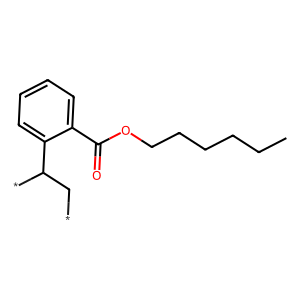

In [5]:
mol = Molecule(subset_df['SMILES'][0], input_type='smiles')
mol.visualize()

In [6]:
df = pd.read_csv(subset_path)
print(f"Loaded {len(df)} molecules.")

Loaded 7973 molecules.


In [7]:
df.head(5)

,SMILES,Tg,FFV,Tc,Density,Rg
0,*C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OC...,NaN,0.386695,NaN,NaN,NaN
1,*CC(=O)NCCCCCCNC(=O)Cc1ccc(O*)cc1,NaN,0.335504,NaN,NaN,NaN
2,*CC(*)c1ccccc1C(=O)NC,NaN,0.355580,0.183667,NaN,NaN
3,*c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(-...,NaN,0.401573,NaN,NaN,NaN
4,*CC(*)OC(=O)c1ccc(-c2ccccc2)cc1,NaN,0.353609,NaN,NaN,NaN


In [8]:
missing_values = df.isnull().sum()
total_rows = len(df)
percent_missing = (missing_values / total_rows) * 100

missing_df = pd.DataFrame({
    'Total Missing': missing_values,
    'Percent Missing': percent_missing
})

print("Missing Values by Column:")
print(missing_df)
print("\nFeature Statistics (Min, Max, Mean, etc.):")
print(df[['Tg', 'FFV', 'Tc', 'Density', 'Rg']].describe())

Missing Values by Column:
         Total Missing  Percent Missing
SMILES               0         0.000000
Tg                7462        93.590869
FFV                943        11.827418
Tc                7236        90.756303
Density           7360        92.311551
Rg                7359        92.299009

Feature Statistics (Min, Max, Mean, etc.):
               Tg          FFV          Tc     Density          Rg
count  511.000000  7030.000000  737.000000  613.000000  614.000000
mean    96.452314     0.367212    0.256334    0.985484   16.419787
std    111.228279     0.029609    0.089538    0.146189    4.608640
min   -148.029738     0.226992    0.046500    0.748691    9.728355
25%     13.674509     0.349549    0.186000    0.890243   12.540328
50%     74.040183     0.364264    0.236000    0.948193   15.052194
75%    161.147595     0.380790    0.330500    1.062096   20.411067
max    472.250000     0.777097    0.524000    1.840999   34.672906


The only property that appears will succeed with a simple imputation strategy is FFV. All other properties contain very high percent missing. Therefore, I will impute median for FFV, train a model for FFV, and train separate models for other properties. I will attempt to filter out missing values for each property. If this yields uncessful, I may explore sampling techniques or use the trained model to impute values to train a secondaery model. |

# Tc Model

In [9]:
# 1. Create a new DataFrame with only the SMILES and Tc columns
df_tc = df[['SMILES', 'Tc']].copy()

print("Initial Tc DataFrame shape:", df_tc.shape)
print("Initial Tc Missing Values:")
print(df_tc.isnull().sum())

# 2. Drop all rows where the 'Tc' value is missing
df_tc.dropna(subset=['Tc'], inplace=True)

print("\nCleaned Tc DataFrame shape:", df_tc.shape)
print("Cleaned Tc Missing Values:")
print(df_tc.isnull().sum())

Initial Tc DataFrame shape: (7973, 2)
Initial Tc Missing Values:
SMILES       0
Tc        7236
dtype: int64

Cleaned Tc DataFrame shape: (737, 2)
Cleaned Tc Missing Values:
SMILES    0
Tc        0
dtype: int64


In [10]:
from rdkit.Chem import AllChem, Descriptors, HybridizationType, SanitizeFlags
def rdkit_ogb_agree(smi: str) -> bool:
    m = Chem.MolFromSmiles(smi)
    if m is None:
        return False
    return m.GetNumAtoms() == smiles2graph(smi)["num_nodes"]

def canonicalize_polymer_smiles(smiles: str, cap_atomic_num: int = 6) -> str:
    """
    Turn every '*' (dummy atom) into a real atom (default C) in the RDKit graph,
    preserving existing bond orders/stereo; sanitize, remove explicit Hs, and
    return canonical isomeric SMILES.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    if mol is None:
        raise ValueError(f"RDKit could not parse SMILES: {smiles}")

    rw = Chem.RWMol(mol)
    for a in rw.GetAtoms():
        if a.GetAtomicNum() == 0:   # '*'
            a.SetAtomicNum(cap_atomic_num)  # 6 = carbon
            a.SetFormalCharge(0)
            a.SetIsAromatic(False)
            a.SetNoImplicit(False)
            a.SetNumExplicitHs(0)

    mol2 = rw.GetMol()
    try:
        Chem.SanitizeMol(mol2)
    except Exception:
        Chem.SanitizeMol(mol2, sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ SanitizeFlags.SANITIZE_KEKULIZE)
        Chem.Kekulize(mol2, clearAromaticFlags=True)

    mol2 = Chem.RemoveHs(mol2)
    return Chem.MolToSmiles(mol2, isomericSmiles=True, canonical=True)

In [11]:
# Build the molecule list
valid_mol_objs = []
valid_targets = []  # Now stores an array with one value per molecule

for i, row in df_tc.iterrows():
    smi = row['SMILES']
    
    # 2.a Clean the SMILES first
    cleaned_smiles = canonicalize_polymer_smiles(smi)

    try:
        # 2.b Create your custom Molecule from the cleaned string
        mol = Molecule(cleaned_smiles, input_type='smiles')
        mol.hydrogens('add')
        mol.to_xyz(optimizer='MMFF', maxIters=200)

        # 2.c Only keep molecules that got a 3-D geometry
        if mol.xyz is not None:
            valid_mol_objs.append(mol)
            
            # Keep only the 'Tc' target column as a NumPy array
            valid_targets.append(
                row[['Tc']].values
            )
        else:
            print(f"Skipped bc missing xyz: {smi}")

    except Exception as e:
        print(f"Failed on {smi} | Reason: {e}")

print(f"Kept {len(valid_mol_objs)} molecules after filtering.")

df_clean = pd.DataFrame({
    'SMILES': [m.smiles for m in valid_mol_objs],
    'Tc':     [t[0] for t in valid_targets],
})
print(f"Kept {len(df_clean)} molecules after filtering.")
df_clean.to_csv('cleaned_tc_dataset.csv', index=False)
print("Saved cleaned Tc dataset to 'cleaned_tc_dataset.csv'.")

y = np.array([t[0] for t in valid_targets])
print("Target shape:", y.shape)

# Your feature computation will now work correctly
fp_featurizer = RDKitFingerprint(
    fingerprint_type='morgan', vector='bit', n_bits=1024, radius=3
)
X_fp = fp_featurizer.represent(valid_mol_objs)

print("RDKit FP shape:", X_fp.shape)

Failed on */C=C/CCCCCCCCCC(CCCCCCCCC*)COCCOCCOCCOCCOCCCCCC | Reason: Bad Conformer Id
Failed on *c1ccc2c(c1)C(CCCCCC)(CCCCCC)c1cc(-c3cc(CCCCCCCCCC)c(*)cc3CCCCCCCCCC)ccc1-2 | Reason: Bad Conformer Id
Failed on */C=C/c1cc(OCCCCCCCCCCCCCCCC)c(/C=C/c2ccc(*)cc2)cc1OCCCCCCCCCCCCCCCC | Reason: Bad Conformer Id
Kept 734 molecules after filtering.
Kept 734 molecules after filtering.
Saved cleaned Tc dataset to 'cleaned_tc_dataset.csv'.
Target shape: (734,)
RDKit FP shape: (734, 1024)


In [12]:
# # 1. make separate train/test splits for both scaled and unscaled targets
# # scaled targets (MLP, KRR, GNN)
# X_train_fp_scaled, X_test_fp_scaled, y_train_scaled, y_test_scaled = train_test_split(
#     X_fp, y, test_size=0.2, random_state=42
# )
# # X_train_cm_scaled, X_test_cm_scaled, _, _ = train_test_split(
# #     X_cm, y, test_size=0.2, random_state=42
# # )

# xscaler_fp = StandardScaler()
# # xscaler_cm = StandardScaler()
# yscaler = StandardScaler()

# X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp_scaled)
# X_test_fp_scaled  = xscaler_fp.transform(X_test_fp_scaled)

# # X_train_cm_scaled = xscaler_cm.fit_transform(X_train_cm_scaled)
# # X_test_cm_scaled  = xscaler_cm.transform(X_test_cm_scaled)

# y_train_scaled = yscaler.fit_transform(y_train_scaled)
# y_test_scaled  = yscaler.transform(y_test_scaled)

# # b) unscaled targets (Random Forest)
# y_unscaled = y              
# X_train_fp_unscaled, X_test_fp_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(
#     X_fp, y_unscaled, test_size=0.2, random_state=42
# )

# # 2. show shapes
# tools.display_dataframe_to_user(
#     name="Cleaned Feature Splits",
#     dataframe=pd.DataFrame({
#         "Split": [
#             "X_train_fp_scaled", "X_test_fp_scaled",
#             # "X_train_cm_scaled", "X_test_cm_scaled",
#             "y_train_scaled",   "y_test_scaled",
#             "X_train_fp_unscaled", "X_test_fp_unscaled",
#             "y_train_unscaled",   "y_test_unscaled"
#         ],
#         "Shape": [
#             X_train_fp_scaled.shape, X_test_fp_scaled.shape,
#             # X_train_cm_scaled.shape, X_test_cm_scaled.shape,
#             y_train_scaled.shape,   y_test_scaled.shape,
#             X_train_fp_unscaled.shape, X_test_fp_unscaled.shape,
#             y_train_unscaled.shape,   y_test_unscaled.shape
#         ]
#     })
# )

# 1. make separate train/test splits for both scaled and unscaled targets
# a) Scaled targets (for KRR)
# Your y is now a 1D array of FFV values.
X_train_fp, X_test_fp, y_train, y_test = train_test_split(
    X_fp, y, test_size=0.2, random_state=42
)

xscaler_fp = StandardScaler()
yscaler = StandardScaler()

X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp)
X_test_fp_scaled = xscaler_fp.transform(X_test_fp)

# Reshape y arrays for the StandardScaler
y_train_scaled = yscaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = yscaler.transform(y_test.reshape(-1, 1))

# b) Unscaled targets (for models that don't need scaling, like Random Forest)
# These are the original, unscaled splits. You can use the variables you already created.
X_train_fp_unscaled = X_train_fp
X_test_fp_unscaled = X_test_fp
y_train_unscaled = y_train
y_test_unscaled = y_test

# 2. show shapes
# The shape display now reflects the single target variable
tools.display_dataframe_to_user(
    name="Cleaned Feature Splits",
    dataframe=pd.DataFrame({
        "Split": [
            "X_train_fp_scaled", "X_test_fp_scaled",
            "y_train_scaled", "y_test_scaled",
            "X_train_fp_unscaled", "X_test_fp_unscaled",
            "y_train_unscaled", "y_test_unscaled"
        ],
        "Shape": [
            X_train_fp_scaled.shape, X_test_fp_scaled.shape,
            y_train_scaled.shape, y_test_scaled.shape,
            X_train_fp_unscaled.shape, X_test_fp_unscaled.shape,
            y_train_unscaled.shape, y_test_unscaled.shape
        ]
    })
)

Cleaned Feature Splits


## Kernel Ridge Regression baseline first

In [13]:
# Kernel Ridge on RDKit fingerprints
krr = KernelRidge(kernel='rbf', alpha=1.0)
krr.fit(X_train_fp_scaled, y_train_scaled)

# predict on scaled test set
y_pred_krr_scaled = krr.predict(X_test_fp_scaled)

# Inverse transform predictions and test targets to compare with unscaled values
# You must reshape y_pred_krr_scaled and y_test_scaled to 2D before inverse transforming
y_pred_krr = yscaler.inverse_transform(y_pred_krr_scaled.reshape(-1, 1)).flatten()
y_test_krr = yscaler.inverse_transform(y_test_scaled).flatten()

# Eval against true unscaled test target
print("Kernel Ridge (RDKit FP)")
metrics_krr = regression_metrics(y_test_krr, y_pred_krr)
print(metrics_krr[['MAE', 'RMSE', 'r_squared']])

Kernel Ridge (RDKit FP)
        MAE      RMSE  r_squared
0  0.043319  0.054998   0.570665


## Random Forest Regression baseline 

In [14]:
# Random Forest (RDKit FP) 
rfr = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
rfr.fit(X_train_fp_unscaled, y_train_unscaled)
# predict
y_pred_rfr = rfr.predict(X_test_fp_unscaled)
# eval
print("Random Forest (RDKit FP)")
metrics_rfr = regression_metrics(y_test_unscaled, y_pred_rfr)
print(metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Random Forest (RDKit FP)
        MAE      RMSE  r_squared
0  0.027697  0.036958   0.806126


## Multi-Layer Perceptron with Morgan Fingerprints baseline 

In [15]:
# MLP (Fingerprint)
mlp_fp = MLP(
    engine='tensorflow',
    nfeatures=X_train_fp_scaled.shape[1],
    nneurons=[64, 128], # These are the hidden layers
    activations=['ReLU', 'ReLU'],
    learning_rate=0.01,
    alpha=0.001,
    nepochs=200,
    batch_size=64,
    loss='mean_squared_error',
    is_regression=True
)

mlp_fp.fit(X=X_train_fp_scaled, y=y_train_scaled.ravel()) # Use .ravel() to convert to 1D
y_pred_fp_scaled = mlp_fp.predict(X_test_fp_scaled)
# Reshape the output from predict() to 2D before inverse transforming
y_pred_fp = yscaler.inverse_transform(y_pred_fp_scaled.reshape(-1, 1)).flatten()
y_test_fp = yscaler.inverse_transform(y_test_scaled).flatten()

# Eval against true unscaled test target
print("MLP (RDKit FP)")
metrics_mlp = regression_metrics(y_test, y_pred_fp)
print(metrics_mlp[['MAE', 'RMSE', 'r_squared']])

Epoch 1/200
10/10 [==============================] - 0s 2ms/step - loss: 1.5430
Epoch 2/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6890
Epoch 3/200
10/10 [==============================] - 0s 2ms/step - loss: 0.4202
Epoch 4/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3539
Epoch 5/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3172
Epoch 6/200
10/10 [==============================] - 0s 2ms/step - loss: 0.2939
Epoch 7/200
10/10 [==============================] - 0s 2ms/step - loss: 0.2804
Epoch 8/200
10/10 [==============================] - 0s 2ms/step - loss: 0.2741
Epoch 9/200
10/10 [==============================] - 0s 2ms/step - loss: 0.2736
Epoch 10/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2749
Epoch 11/200
10/10 [==============================] - 0s 2ms/step - loss: 0.2699
Epoch 12/200
10/10 [==============================] - 0s 2ms/step - loss: 0.2683
Epoch 13/200
10/10 [=================

## Multi-Layer Perceptron with Coulomb Matrix representation baseline 

In [16]:
# # MLP (Coulomb matrix)
# mlp_cm = MLP(
#     engine='tensorflow', 
#     nfeatures=X_train_cm_scaled.shape[1], 
#     nneurons=[64, 128], 
#     activations=['ReLU', 'ReLU'],
#     learning_rate=0.0001, 
#     alpha=0.001, 
#     nepochs=100, 
#     batch_size=64, 
#     loss='mean_squared_error', 
#     is_regression=True
#     )

# mlp_cm.fit(X=X_train_cm_scaled, y=y_train_scaled)
# y_pred_cm_scaled = mlp_cm.predict(X_test_cm_scaled)
# y_pred_cm = yscaler.inverse_transform(y_pred_cm_scaled)
# y_test_cm = yscaler.inverse_transform(y_test_scaled)

In [17]:
# eval
results = {"Kernel Ridge (RDKit FP)": regression_metrics(y_test_krr, y_pred_krr),
           "Random Forest (RDKit FP)": regression_metrics(y_test_unscaled, y_pred_rfr),
           "MLP (RDKit FP)": regression_metrics(y_test_fp, y_pred_fp),
        #    "MLP (Coulomb Matrix)": regression_metrics(y_test_cm, y_pred_cm)
        }

# display
print("Final Model Comparison")
for name, metrics_df in results.items():
    print(f"\n{name}")
    print(metrics_df[['MAE', 'RMSE', 'r_squared']])

Final Model Comparison

Kernel Ridge (RDKit FP)
        MAE      RMSE  r_squared
0  0.043319  0.054998   0.570665

Random Forest (RDKit FP)
        MAE      RMSE  r_squared
0  0.027697  0.036958   0.806126

MLP (RDKit FP)
        MAE      RMSE  r_squared
0  0.036819  0.052244   0.612592


## Parity Plots and Residuals Histograms

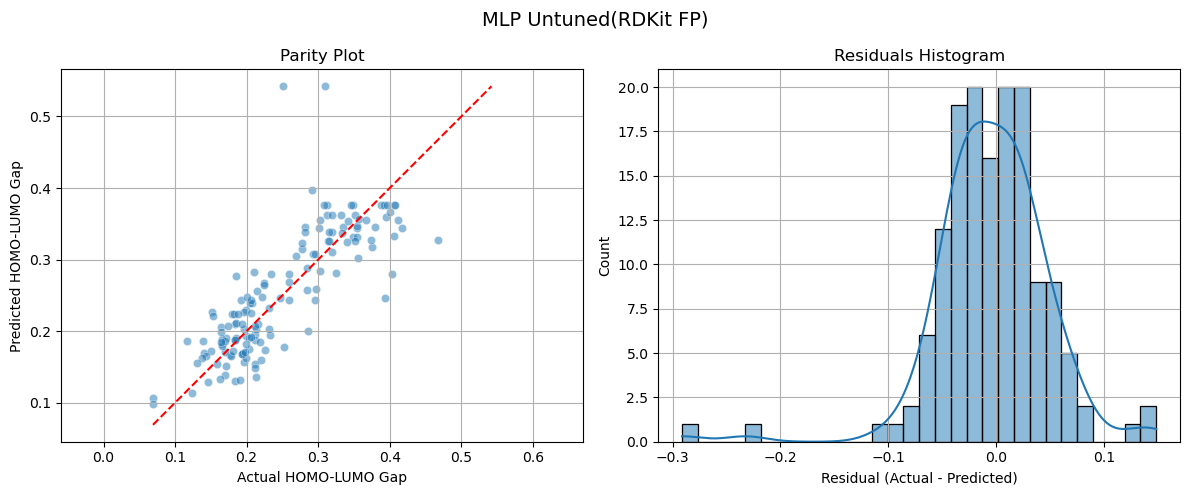

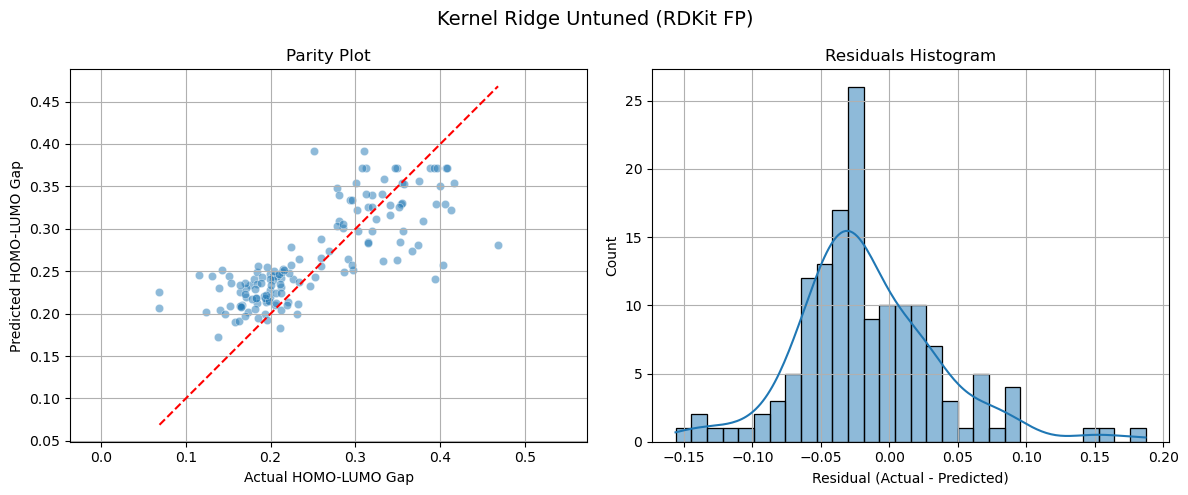

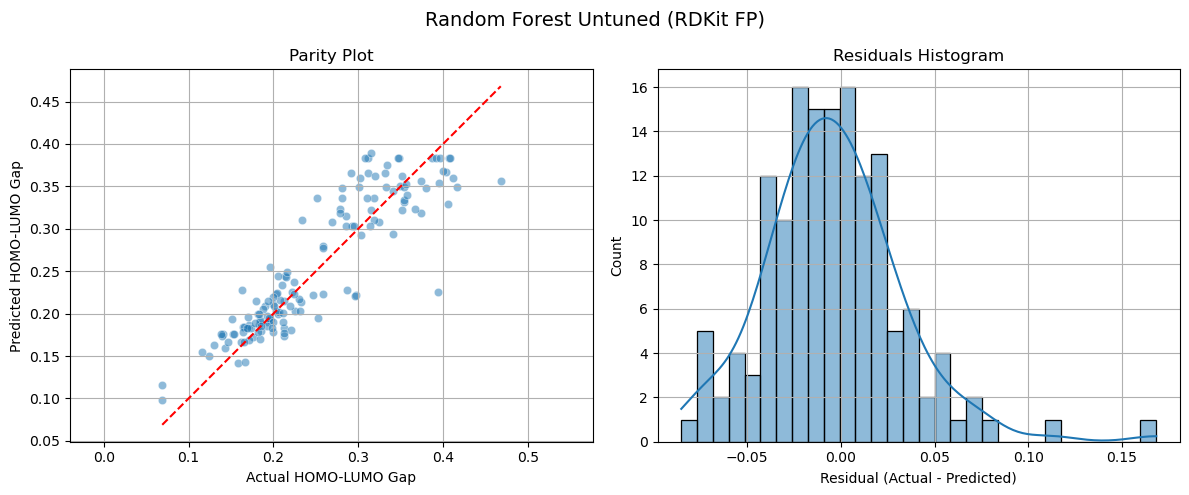

In [18]:
def plot_regression_results(y_true, y_pred, title="Model Evaluation", save_dir="plots"):
    residuals = y_true.flatten() - y_pred.flatten()
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # parity plot
    sns.scatterplot(ax=axes[0], x=y_true.flatten(), y=y_pred.flatten(), alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], '--r')
    axes[0].set_xlabel("Actual HOMO-LUMO Gap")
    axes[0].set_ylabel("Predicted HOMO-LUMO Gap")
    axes[0].set_title("Parity Plot")
    axes[0].grid(True)
    axes[0].axis('equal')

    # residuals histogram
    sns.histplot(ax=axes[1], data=residuals, bins=30, kde=True)
    axes[1].set_title("Residuals Histogram")
    axes[1].set_xlabel("Residual (Actual - Predicted)")
    axes[1].grid(True)

    # overall title
    fig.suptitle(title, fontsize=14)

    # save fig as pdf for best overleaf upload format 
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f"{title.lower().replace(' ', '_')}_plots.pdf")
    fig.savefig(filename, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

plot_regression_results(y_test_fp, y_pred_fp, title="MLP Untuned(RDKit FP)")
# plot_regression_results(y_test_cm, y_pred_cm, title="MLP Untuned (Coulomb Matrix)")
plot_regression_results(y_test_krr, y_pred_krr, title="Kernel Ridge Untuned (RDKit FP)")
plot_regression_results(y_test_unscaled, y_pred_rfr, title="Random Forest Untuned (RDKit FP)")

## Tune hyperparameters for baseline models with Optuna 

In [19]:
def objective_krr(trial):
    alpha = trial.suggest_float('alpha', 0.01, 1.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    gamma = trial.suggest_float('gamma', 1e-5, 1.0, log=True) if kernel == 'rbf' else None
    model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma) if gamma else KernelRidge(alpha=alpha, kernel=kernel)
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_krr = optuna.create_study(direction='minimize')
study_krr.optimize(objective_krr, n_trials=100)

[I 2025-09-04 17:52:49,844] A new study created in memory with name: no-name-f0d04ae2-d7ba-433a-ac3f-5fdeb126068f
[I 2025-09-04 17:52:49,888] Trial 0 finished with value: 0.06070841324106652 and parameters: {'alpha': 0.01290189166605266, 'kernel': 'rbf', 'gamma': 0.17078346070714076}. Best is trial 0 with value: 0.06070841324106652.
[I 2025-09-04 17:52:49,946] Trial 1 finished with value: 0.061279364703200154 and parameters: {'alpha': 0.6994553343961674, 'kernel': 'rbf', 'gamma': 0.24165874902244439}. Best is trial 0 with value: 0.06070841324106652.
[I 2025-09-04 17:52:49,961] Trial 2 finished with value: 0.058966099683835885 and parameters: {'alpha': 0.510776494889568, 'kernel': 'linear'}. Best is trial 2 with value: 0.058966099683835885.
[I 2025-09-04 17:52:49,977] Trial 3 finished with value: 0.06091392460870651 and parameters: {'alpha': 0.1199368909262727, 'kernel': 'linear'}. Best is trial 2 with value: 0.058966099683835885.
[I 2025-09-04 17:52:49,993] Trial 4 finished with value:

In [20]:
def objective_rfr(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    max_depth = trial.suggest_int("max_depth", 10, 100, step=10)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
    model.fit(X_train_fp_unscaled, y_train_unscaled)
    preds = model.predict(X_test_fp_unscaled)
    metrics = regression_metrics(y_test_unscaled, preds)
    return metrics['MAE'][0]

study_rfr = optuna.create_study(direction='minimize')
study_rfr.optimize(objective_rfr, n_trials=100)

[I 2025-09-04 17:52:55,761] A new study created in memory with name: no-name-471ceb16-8102-47d2-9de6-8ab34e38838b
[I 2025-09-04 17:52:56,605] Trial 0 finished with value: 0.02760360560262208 and parameters: {'n_estimators': 300, 'max_depth': 40}. Best is trial 0 with value: 0.02760360560262208.
[I 2025-09-04 17:52:57,451] Trial 1 finished with value: 0.027603605602622094 and parameters: {'n_estimators': 300, 'max_depth': 40}. Best is trial 0 with value: 0.02760360560262208.
[I 2025-09-04 17:52:58,160] Trial 2 finished with value: 0.027542072889710015 and parameters: {'n_estimators': 250, 'max_depth': 80}. Best is trial 2 with value: 0.027542072889710015.
[I 2025-09-04 17:52:58,826] Trial 3 finished with value: 0.0274395942219203 and parameters: {'n_estimators': 200, 'max_depth': 70}. Best is trial 3 with value: 0.0274395942219203.
[I 2025-09-04 17:52:59,257] Trial 4 finished with value: 0.027603435832758136 and parameters: {'n_estimators': 150, 'max_depth': 20}. Best is trial 3 with va

In [22]:
def objective_mlp_fp(trial):
    lr = trial.suggest_float('lr', 1e-4, 2e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-4, 5e-2, log=True)
    act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
    n1 = trial.suggest_int('n1', 128, 384, step=64)
    n2 = trial.suggest_int('n2', 128, 384, step=64)

    model = MLP(engine='tensorflow', nfeatures=X_train_fp_scaled.shape[1], nneurons=[n1, n2],
                activations=[act, act], learning_rate=lr, alpha=alpha,
                nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)
    
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_mlp_fp = optuna.create_study(direction='minimize')
study_mlp_fp.optimize(objective_mlp_fp, n_trials=100)

[I 2025-09-04 18:05:06,843] A new study created in memory with name: no-name-b8dbc07e-7249-44e0-9799-c25371f1e87a


Epoch 1/100
10/10 [==============================] - 0s 4ms/step - loss: 2.2072
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 1.6547
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 1.4584
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 1.4084
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 1.3682
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 1.3423
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 1.3305
Epoch 8/100
10/10 [==============================] - 0s 3ms/step - loss: 1.3148
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 1.2951
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 1.2869
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 1.2762
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 1.2692
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:05:09,344] Trial 0 finished with value: 0.04424286746954432 and parameters: {'lr': 0.0033659755034473856, 'alpha': 0.003068219749980747, 'activation': 'relu', 'n1': 128, 'n2': 320}. Best is trial 0 with value: 0.04424286746954432.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 2.6260
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 2.2037
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 1.9595
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 1.8478
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 1.7866
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 1.7449
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 1.7164
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6931
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6750
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6623
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6506
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 1.6419
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:05:11,483] Trial 1 finished with value: 0.05068337308863545 and parameters: {'lr': 0.0004784821455510965, 'alpha': 0.002448935828905268, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 0 with value: 0.04424286746954432.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 1.2413
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 1.1222
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 0.9881
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 0.8676
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 0.7684
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 0.6863
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 0.6207
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5685
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5237
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4898
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4568
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4315
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:05:13,850] Trial 2 finished with value: 0.050095735616856964 and parameters: {'lr': 0.00013849593932803856, 'alpha': 0.00010640247459633818, 'activation': 'gelu', 'n1': 256, 'n2': 384}. Best is trial 0 with value: 0.04424286746954432.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 4.5870
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 4.1002
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 4.0234
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 3.9670
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 3.8879
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 3.8117
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 3.7597
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 3.6958
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 3.6964
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 3.6002
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 3.5344
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 3.4614
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:05:16,029] Trial 3 finished with value: 0.03676993908555059 and parameters: {'lr': 0.0015096577237997107, 'alpha': 0.004669444375344414, 'activation': 'sigmoid', 'n1': 256, 'n2': 256}. Best is trial 3 with value: 0.03676993908555059.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 0.9343
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 0.8274
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4697
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 0.2882
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 0.1842
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 0.1518
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1515
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1453
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1266
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1266
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1170
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1158
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:05:18,522] Trial 4 finished with value: 0.03949327331094785 and parameters: {'lr': 0.007758292678493508, 'alpha': 0.00010776517068815283, 'activation': 'gelu', 'n1': 128, 'n2': 320}. Best is trial 3 with value: 0.03676993908555059.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 4.8066
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 4.2605
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 4.0253
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 3.8861
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 3.7497
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 3.6374
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 3.5320
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 3.4404
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 3.3533
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 3.2848
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 3.1958
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 3.1148
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:05:20,687] Trial 5 finished with value: 0.04310891393633927 and parameters: {'lr': 0.007705497476267901, 'alpha': 0.00829750207293368, 'activation': 'tanh', 'n1': 192, 'n2': 128}. Best is trial 3 with value: 0.03676993908555059.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 4.1372
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 3.4031
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 3.1613
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 3.0951
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 3.0084
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 2.9756
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 2.9554
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 2.9408
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 2.9267
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 2.9059
Epoch 11/100
10/10 [==============================] - 0s 3ms/step - loss: 2.8901
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 2.8762
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:05:22,919] Trial 6 finished with value: 0.041120172545780126 and parameters: {'lr': 0.0023075069649188206, 'alpha': 0.004232402331661968, 'activation': 'relu', 'n1': 256, 'n2': 320}. Best is trial 3 with value: 0.03676993908555059.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 2.4437
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 2.0434
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6877
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6993
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 1.5743
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 1.5094
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 1.4921
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 1.4588
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 1.4609
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 1.4563
Epoch 11/100
10/10 [==============================] - 0s 3ms/step - loss: 1.4161
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 1.3992
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:05:25,003] Trial 7 finished with value: 0.04026037968383625 and parameters: {'lr': 0.01466913256607746, 'alpha': 0.0015725835451457619, 'activation': 'tanh', 'n1': 384, 'n2': 320}. Best is trial 3 with value: 0.03676993908555059.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 3.5262
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 1.9866
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 1.7311
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 1.5336
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 1.3984
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 1.3483
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2911
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2401
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 1.1924
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 1.1301
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 1.0859
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 1.0421
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:05:27,196] Trial 8 finished with value: 0.036394308211338496 and parameters: {'lr': 0.0011872759664016738, 'alpha': 0.0007419049570362019, 'activation': 'sigmoid', 'n1': 320, 'n2': 192}. Best is trial 8 with value: 0.036394308211338496.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 1.0695
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4746
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 0.3123
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 0.2282
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1973
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1692
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1552
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1513
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1458
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1730
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1615
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 0.1490
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:05:29,334] Trial 9 finished with value: 0.044498424738334694 and parameters: {'lr': 0.005410259672692185, 'alpha': 0.00010898503931469556, 'activation': 'tanh', 'n1': 256, 'n2': 320}. Best is trial 8 with value: 0.036394308211338496.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 32.4711
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 32.3034
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 32.0376
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 31.7712
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 31.4910
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 31.2172
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 30.9474
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 30.6723
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 30.4097
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 30.1409
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 29.8817
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 29.6211
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:05:31,442] Trial 10 finished with value: 0.03484022633683384 and parameters: {'lr': 0.0004895745433312479, 'alpha': 0.04189911429303109, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 10 with value: 0.03484022633683384.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 35.5876
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 35.2782
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 34.9833
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 34.6562
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 34.3401
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 34.0202
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 33.7020
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 33.3844
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 33.0786
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 32.7676
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 32.4657
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 32.1641
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:05:33,575] Trial 11 finished with value: 0.034614601965285756 and parameters: {'lr': 0.00048332303285784884, 'alpha': 0.04591231036148005, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 11 with value: 0.034614601965285756.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 31.8904
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 31.7417
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 31.5182
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 31.2978
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 31.0668
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 30.8391
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 30.6140
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 30.3842
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 30.1646
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 29.9395
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 29.7203
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 29.5009
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:05:35,705] Trial 12 finished with value: 0.03491743537157842 and parameters: {'lr': 0.0004269224121826945, 'alpha': 0.04112488570414258, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 11 with value: 0.034614601965285756.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 32.8913
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 32.6717
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 32.4728
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 32.2464
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 32.0376
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 31.8218
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 31.6112
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 31.3887
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 31.1838
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 30.9685
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 30.7640
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 30.5551
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:05:37,806] Trial 13 finished with value: 0.034291270112937276 and parameters: {'lr': 0.0004064826182536392, 'alpha': 0.03905543405975425, 'activation': 'sigmoid', 'n1': 384, 'n2': 192}. Best is trial 13 with value: 0.034291270112937276.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 14.1434
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 14.1272
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 14.0977
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 14.0665
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 14.0369
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 14.0072
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 13.9759
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 13.9435
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 13.9147
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 13.8841
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 13.8540
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 13.8234
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:05:39,945] Trial 14 finished with value: 0.03897421388739632 and parameters: {'lr': 0.0002176530675964048, 'alpha': 0.01801559615974018, 'activation': 'sigmoid', 'n1': 320, 'n2': 192}. Best is trial 13 with value: 0.034291270112937276.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 13.6375
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 13.4954
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 13.3592
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 13.2636
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 13.1475
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 13.0483
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 12.9508
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 12.8469
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 12.7427
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 12.6365
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 12.5416
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 12.4401
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:05:42,105] Trial 15 finished with value: 0.03514836712072766 and parameters: {'lr': 0.000847454312619668, 'alpha': 0.017194284664617376, 'activation': 'sigmoid', 'n1': 320, 'n2': 192}. Best is trial 13 with value: 0.034291270112937276.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 14.8572
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 14.2923
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 14.2894
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 14.2329
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 14.2051
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 14.1965
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 14.1749
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 14.1602
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 14.1484
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 14.1346
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 14.1206
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 14.1068
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:05:44,238] Trial 16 finished with value: 0.05122293622547807 and parameters: {'lr': 0.0001006805314791961, 'alpha': 0.015272268476411492, 'activation': 'sigmoid', 'n1': 384, 'n2': 256}. Best is trial 13 with value: 0.034291270112937276.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 32.0728
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 31.8128
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 31.6928
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 31.5150
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 31.3735
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 31.2231
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 31.0694
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 30.9210
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 30.7742
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 30.6273
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 30.4815
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 30.3361
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:05:46,348] Trial 17 finished with value: 0.037766945281158495 and parameters: {'lr': 0.0002471565171398959, 'alpha': 0.04587051326948574, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 13 with value: 0.034291270112937276.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6442
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 1.0490
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 0.8077
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 0.6965
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 0.6149
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5726
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5463
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5282
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5190
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5110
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5025
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4963
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:05:48,712] Trial 18 finished with value: 0.049099128999434354 and parameters: {'lr': 0.0006952060903561229, 'alpha': 0.0004650249741061298, 'activation': 'gelu', 'n1': 384, 'n2': 256}. Best is trial 13 with value: 0.034291270112937276.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 7.9410
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 7.7022
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 7.6543
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 7.6102
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 7.5936
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 7.5746
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 7.5591
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 7.5390
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 7.5252
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 7.5088
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 7.4932
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 7.4768
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:05:50,804] Trial 19 finished with value: 0.037531697748631854 and parameters: {'lr': 0.0002358552297391443, 'alpha': 0.009096201864895027, 'activation': 'sigmoid', 'n1': 320, 'n2': 192}. Best is trial 13 with value: 0.034291270112937276.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 11.4714
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 11.4459
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 11.4067
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 11.3619
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 11.3202
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 11.2776
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 11.2331
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 11.1892
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 11.1478
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 11.1057
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 11.0626
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 11.0204
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:05:53,010] Trial 20 finished with value: 0.03531096322212089 and parameters: {'lr': 0.00032338990970867725, 'alpha': 0.021908005528560117, 'activation': 'sigmoid', 'n1': 192, 'n2': 128}. Best is trial 13 with value: 0.034291270112937276.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 25.5183
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 25.3118
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 25.0964
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 24.8559
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 24.6232
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 24.3900
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 24.1638
Epoch 8/100
10/10 [==============================] - 0s 3ms/step - loss: 23.9275
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 23.7057
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 23.4765
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 23.2578
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 23.0374
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:05:55,147] Trial 21 finished with value: 0.034014301978703795 and parameters: {'lr': 0.0006625315318839594, 'alpha': 0.03260148419251299, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 21 with value: 0.034014301978703795.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 22.8400
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 22.6784
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 22.4222
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 22.1590
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 21.8989
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 21.6453
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 21.3995
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 21.1452
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 20.8999
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 20.6558
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 20.4205
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 20.1856
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:05:57,293] Trial 22 finished with value: 0.036300175011590496 and parameters: {'lr': 0.0008798882640203166, 'alpha': 0.029069953222176283, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 21 with value: 0.034014301978703795.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 10.4160
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 9.5258
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 9.3115
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 9.1683
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 9.0235
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 8.8829
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 8.7692
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 8.6504
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 8.5840
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 8.4532
Epoch 11/100
10/10 [==============================] - 0s 3ms/step - loss: 8.3424
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 8.2323
Epoch 13/100
10/10 [================

[I 2025-09-04 18:05:59,427] Trial 23 finished with value: 0.03553322259885113 and parameters: {'lr': 0.0017282373102776587, 'alpha': 0.010406375732998966, 'activation': 'sigmoid', 'n1': 384, 'n2': 192}. Best is trial 21 with value: 0.034014301978703795.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 20.2964
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 19.8588
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 19.6146
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 19.4067
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 19.2604
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 19.0964
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 18.9455
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 18.7787
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 18.6322
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 18.4733
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 18.3261
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 18.1738
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:01,567] Trial 24 finished with value: 0.03390118374105483 and parameters: {'lr': 0.0006474830345639625, 'alpha': 0.02807396460135861, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 24 with value: 0.03390118374105483.


Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 19.6517
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 19.5412
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 19.3726
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 19.2011
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 19.0242
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 18.8513
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 18.6864
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 18.5152
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 18.3403
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 18.1701
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 18.0080
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 17.8421
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:03,789] Trial 25 finished with value: 0.03733822207375179 and parameters: {'lr': 0.0007621111764812654, 'alpha': 0.025648736727515373, 'activation': 'sigmoid', 'n1': 320, 'n2': 192}. Best is trial 24 with value: 0.03390118374105483.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 9.2969
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 8.7655
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 8.5235
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 8.3245
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 8.1791
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 8.0857
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 8.0126
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 7.9578
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 7.9121
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 7.8777
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 7.8450
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 7.8191
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:06:06,438] Trial 26 finished with value: 0.05262303717447247 and parameters: {'lr': 0.00016072050478548348, 'alpha': 0.0113786161948614, 'activation': 'gelu', 'n1': 320, 'n2': 128}. Best is trial 24 with value: 0.03390118374105483.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 5.6634
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 5.1819
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 4.9866
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 4.8914
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 4.8455
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 4.8074
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 4.7758
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 4.7535
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 4.7329
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 4.7210
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 4.7001
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 4.6863
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:06:08,569] Trial 27 finished with value: 0.046930982771806434 and parameters: {'lr': 0.0011047235535979842, 'alpha': 0.006136137448092078, 'activation': 'tanh', 'n1': 320, 'n2': 256}. Best is trial 24 with value: 0.03390118374105483.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 24.6317
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 24.1168
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 23.6321
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 23.3830
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 23.2152
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 23.0702
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 22.9510
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 22.8381
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 22.7307
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 22.6307
Epoch 11/100
10/10 [==============================] - 0s 3ms/step - loss: 22.5329
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 22.4386
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:10,761] Trial 28 finished with value: 0.046073481705751006 and parameters: {'lr': 0.0003349455538963299, 'alpha': 0.02848705264434018, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 24 with value: 0.03390118374105483.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 2.0828
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 1.5707
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 1.1692
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 1.1169
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 1.0368
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 1.0052
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 0.9830
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 0.9690
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 0.9630
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 0.9582
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 0.9521
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 0.9486
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:06:12,977] Trial 29 finished with value: 0.044492865997539356 and parameters: {'lr': 0.0036267946838001346, 'alpha': 0.001205553860306194, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 24 with value: 0.03390118374105483.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 1.3914
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 1.1564
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 1.0754
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 1.0064
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 0.9337
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 0.8508
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 0.7811
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 0.7197
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 0.7141
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 0.6858
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5809
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5512
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:06:15,187] Trial 30 finished with value: 0.038412489975688136 and parameters: {'lr': 0.001983787708036847, 'alpha': 0.0002526179795853719, 'activation': 'sigmoid', 'n1': 320, 'n2': 384}. Best is trial 24 with value: 0.03390118374105483.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 38.5579
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 38.1756
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 37.7337
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 37.2504
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 36.7732
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 36.2968
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 35.8321
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 35.3631
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 34.9090
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 34.4547
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 34.0136
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 33.5753
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:17,355] Trial 31 finished with value: 0.03387293905346842 and parameters: {'lr': 0.0006198185874606597, 'alpha': 0.04997488501966526, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 24.7630
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 24.6067
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 24.3525
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 24.1559
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 23.9385
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 23.7331
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 23.5281
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 23.3226
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 23.1248
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 22.9216
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 22.7266
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 22.5297
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:19,495] Trial 32 finished with value: 0.03445758217278522 and parameters: {'lr': 0.0006194104530460645, 'alpha': 0.03161666615154337, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 12.9281
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 12.7455
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 12.6758
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 12.6018
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 12.5644
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 12.5169
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 12.4743
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 12.4190
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 12.3812
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 12.3308
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 12.2906
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 12.2447
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:21,708] Trial 33 finished with value: 0.03481914580884704 and parameters: {'lr': 0.0004000440853507685, 'alpha': 0.014374588710303983, 'activation': 'sigmoid', 'n1': 384, 'n2': 192}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 16.0808
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 15.8727
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 15.7537
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 15.6302
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 15.5367
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 15.4349
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 15.3359
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 15.2294
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 15.1378
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 15.0342
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 14.9403
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 14.8427
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:23,897] Trial 34 finished with value: 0.034101294600395925 and parameters: {'lr': 0.000582502718328547, 'alpha': 0.02220105753231927, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 13.9776
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 13.1385
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 12.8461
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 12.5391
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 12.3774
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 12.2178
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 12.0624
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 11.9256
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 11.7939
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 11.6673
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 11.5401
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 11.4160
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:26,341] Trial 35 finished with value: 0.040230911196521627 and parameters: {'lr': 0.0012097810581832554, 'alpha': 0.021847939219464086, 'activation': 'gelu', 'n1': 256, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 4.3675
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 3.8521
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 3.5858
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 3.4667
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 3.4012
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 3.3491
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 3.3183
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 3.2945
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 3.2737
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 3.2593
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 3.2447
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 3.2327
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:06:28,587] Trial 36 finished with value: 0.04704717673982352 and parameters: {'lr': 0.0006042615794624605, 'alpha': 0.006696063419974212, 'activation': 'relu', 'n1': 192, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 3.3137
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 3.2441
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 3.1460
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 3.0301
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 2.8878
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 2.7734
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 2.6990
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 2.6097
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 2.5963
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 2.5366
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 2.4914
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 2.4441
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:06:30,791] Trial 37 finished with value: 0.03983052418037336 and parameters: {'lr': 0.00287466443416735, 'alpha': 0.0039546073325936616, 'activation': 'sigmoid', 'n1': 256, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 12.2112
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 11.4018
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 11.0576
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 10.7877
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 10.5600
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 10.3513
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 10.1497
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 9.9616
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 9.7768
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 9.6033
Epoch 11/100
10/10 [==============================] - 0s 3ms/step - loss: 9.4243
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 9.2550
Epoch 13/100
10/10 [==========

[I 2025-09-04 18:06:32,979] Trial 38 finished with value: 0.04242450598202595 and parameters: {'lr': 0.001433938140166136, 'alpha': 0.031181383384599894, 'activation': 'tanh', 'n1': 128, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 12.5564
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 12.0272
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 11.9355
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 11.8436
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 11.7257
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 11.6156
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 11.5332
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 11.4471
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 11.4080
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 11.2867
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 11.1910
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 11.0847
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:35,181] Trial 39 finished with value: 0.03463833739619677 and parameters: {'lr': 0.000946370889311331, 'alpha': 0.013217282325348564, 'activation': 'sigmoid', 'n1': 320, 'n2': 384}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 3.1767
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 2.6711
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 2.3719
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 2.2525
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 2.1853
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 2.1410
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 2.1123
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 2.0891
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 2.0721
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 2.0604
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 2.0494
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 2.0413
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:06:37,592] Trial 40 finished with value: 0.05225966363794882 and parameters: {'lr': 0.0005963928856772601, 'alpha': 0.002923344936337842, 'activation': 'gelu', 'n1': 256, 'n2': 256}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 41.2867
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 41.1290
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 40.8942
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 40.6416
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 40.3820
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 40.1232
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 39.8657
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 39.6038
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 39.3520
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 39.0949
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 38.8445
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 38.5931
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:39,797] Trial 41 finished with value: 0.03560221334666081 and parameters: {'lr': 0.00031536041606738203, 'alpha': 0.049483469385130985, 'activation': 'sigmoid', 'n1': 384, 'n2': 192}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 24.5720
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 24.1393
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 23.8893
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 23.6753
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 23.4901
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 23.2968
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 23.1070
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 22.9119
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 22.7322
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 22.5431
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 22.3629
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 22.1804
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:41,950] Trial 42 finished with value: 0.03527931357554568 and parameters: {'lr': 0.0005481375034126958, 'alpha': 0.03470082186391216, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 16.1746
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 15.4572
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 15.2548
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 15.1678
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 15.0807
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 15.0147
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 14.9407
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 14.8732
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 14.8115
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 14.7448
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 14.6815
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 14.6174
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:44,064] Trial 43 finished with value: 0.03457589769055243 and parameters: {'lr': 0.00042562589054996185, 'alpha': 0.019044442413341293, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 20.3899
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 18.3101
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 15.2177
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 12.9715
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 10.8241
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 9.0570
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 7.4310
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 6.1478
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 5.0809
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 4.2311
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 3.5208
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 2.9365
Epoch 13/100
10/10 [============

[I 2025-09-04 18:06:46,229] Trial 44 finished with value: 0.03582100113316728 and parameters: {'lr': 0.018181880143011135, 'alpha': 0.023974032578179347, 'activation': 'sigmoid', 'n1': 384, 'n2': 192}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 24.6957
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 24.3785
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 24.3103
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 24.2361
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 24.1610
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 24.0994
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 24.0336
Epoch 8/100
10/10 [==============================] - 0s 3ms/step - loss: 23.9676
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 23.9055
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 23.8426
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 23.7792
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 23.7162
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:48,410] Trial 45 finished with value: 0.04172169258740484 and parameters: {'lr': 0.00017022492581675487, 'alpha': 0.034759301749523026, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 2.8436
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 2.3903
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 2.1772
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 2.0579
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 1.9792
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 1.9218
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 1.8833
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 1.8545
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 1.8304
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 1.8122
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 1.7954
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 1.7823
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:06:50,513] Trial 46 finished with value: 0.05198166356162419 and parameters: {'lr': 0.0002769341026210422, 'alpha': 0.001992251927158183, 'activation': 'tanh', 'n1': 384, 'n2': 192}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 25.1129
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 24.8399
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 24.4517
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 24.0257
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 23.6161
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 23.2105
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 22.8228
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 22.4317
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 22.0428
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 21.6678
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 21.3015
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 20.9437
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:52,657] Trial 47 finished with value: 0.03626549514907828 and parameters: {'lr': 0.0010882070387110655, 'alpha': 0.035928147221155546, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 13.5528
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 13.1114
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 12.6610
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 12.4541
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 12.3218
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 12.2322
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 12.1568
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 12.0961
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 12.0381
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 11.9886
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 11.9400
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 11.8953
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:54,861] Trial 48 finished with value: 0.05257228738572322 and parameters: {'lr': 0.0003770883951554444, 'alpha': 0.019269411803145346, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 36.7584
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 36.3512
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 35.8699
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 35.3481
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 34.8226
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 34.3063
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 33.8027
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 33.2967
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 32.8037
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 32.3136
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 31.8374
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 31.3656
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:06:56,963] Trial 49 finished with value: 0.03487739530134092 and parameters: {'lr': 0.0007514400471091845, 'alpha': 0.04747119203976021, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 7.1008
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 7.0375
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 6.9544
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 6.9329
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 6.8928
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 6.8630
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 6.8384
Epoch 8/100
10/10 [==============================] - 0s 3ms/step - loss: 6.8035
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 6.7799
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 6.7483
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 6.7225
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 6.6936
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:06:59,164] Trial 50 finished with value: 0.03462329716736497 and parameters: {'lr': 0.00046323244154663465, 'alpha': 0.007936167333847435, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 22.1853
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 21.9811
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 21.8122
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 21.6235
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 21.4521
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 21.2790
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 21.1147
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 20.9387
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 20.7758
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 20.6065
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 20.4462
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 20.2842
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:01,312] Trial 51 finished with value: 0.034473607340799704 and parameters: {'lr': 0.0006103051017245577, 'alpha': 0.028076316025828375, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 28.3332
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 28.1558
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 27.8644
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 27.5930
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 27.3066
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 27.0306
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 26.7545
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 26.4786
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 26.2114
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 25.9399
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 25.6782
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 25.4157
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:03,447] Trial 52 finished with value: 0.03510466381065428 and parameters: {'lr': 0.0006536913685861148, 'alpha': 0.03647203680375388, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 12.5332
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 12.4738
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 12.4191
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 12.3539
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 12.2920
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 12.2322
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 12.1721
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 12.1087
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 12.0544
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 11.9923
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 11.9361
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 11.8786
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:05,578] Trial 53 finished with value: 0.03511222841317962 and parameters: {'lr': 0.00048972665917405, 'alpha': 0.015347781582726358, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 18.7516
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 18.3285
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 17.9596
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 17.7097
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 17.5183
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 17.3494
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 17.1875
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 17.0125
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 16.8523
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 16.6876
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 16.5335
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 16.3749
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:07,795] Trial 54 finished with value: 0.03438218943483435 and parameters: {'lr': 0.0008708794117207987, 'alpha': 0.02282115001282735, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 17.7695
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 17.6386
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 17.4826
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 17.2868
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 17.1199
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 16.9514
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 16.7932
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 16.6348
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 16.4685
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 16.3021
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 16.1487
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 15.9908
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:09,958] Trial 55 finished with value: 0.03705466225076965 and parameters: {'lr': 0.000861963186674178, 'alpha': 0.022989469242027886, 'activation': 'sigmoid', 'n1': 320, 'n2': 192}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 10.3329
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 10.2564
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 10.1367
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 10.0159
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 9.8971
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 9.7865
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 9.6847
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 9.5830
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 9.4704
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 9.3601
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 9.2640
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 9.1692
Epoch 13/100
10/10 [=============

[I 2025-09-04 18:07:12,097] Trial 56 finished with value: 0.03614976016088408 and parameters: {'lr': 0.0012634402119156304, 'alpha': 0.012407675201073186, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 27.1603
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 26.4803
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 26.4203
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 26.3188
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 26.2145
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 26.1317
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 26.0492
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 25.9642
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 25.8814
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 25.7998
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 25.7174
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 25.6354
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:14,217] Trial 57 finished with value: 0.03956219812953283 and parameters: {'lr': 0.00019276896780877554, 'alpha': 0.03811193452117611, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 41.5915
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 40.4523
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 39.6114
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 38.7813
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 37.9968
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 37.2374
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 36.4962
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 35.7781
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 35.0750
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 34.3968
Epoch 11/100
10/10 [==============================] - 0s 3ms/step - loss: 33.7175
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 33.0603
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:16,419] Trial 58 finished with value: 0.043701946075568134 and parameters: {'lr': 0.0009831215087788578, 'alpha': 0.04963866915992179, 'activation': 'tanh', 'n1': 384, 'n2': 192}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 13.3345
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 12.4856
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 12.2085
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 11.9428
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 11.7723
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 11.6002
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 11.4602
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 11.3309
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 11.2077
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 11.0856
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 10.9637
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 10.8460
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:19,071] Trial 59 finished with value: 0.04248201708866625 and parameters: {'lr': 0.0014697310386064563, 'alpha': 0.017995061998251596, 'activation': 'gelu', 'n1': 320, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 23.7903
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 23.6492
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 23.4816
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 23.2631
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 23.0525
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 22.8577
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 22.6673
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 22.4745
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 22.2824
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 22.0624
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 21.8678
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 21.6739
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:21,257] Trial 60 finished with value: 0.03624259594308546 and parameters: {'lr': 0.0007678234022097249, 'alpha': 0.025054554001121568, 'activation': 'sigmoid', 'n1': 384, 'n2': 320}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 23.2280
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 23.0856
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 22.8600
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 22.7133
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 22.5413
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 22.3806
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 22.2248
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 22.0648
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 21.9121
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 21.7544
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 21.6035
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 21.4509
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:23,426] Trial 61 finished with value: 0.034361066037997635 and parameters: {'lr': 0.0005309299780732582, 'alpha': 0.02942552982042354, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.03387293905346842.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 31.5971
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 31.4211
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 31.1400
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 30.8662
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 30.5767
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 30.2945
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 30.0171
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 29.7360
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 29.4668
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 29.1916
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 28.9269
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 28.6605
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:25,800] Trial 62 finished with value: 0.03374249939329229 and parameters: {'lr': 0.0005289640963149378, 'alpha': 0.04071393911764042, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 31.3643
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 31.2623
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 31.1258
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 30.9737
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 30.8273
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 30.6775
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 30.5271
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 30.3777
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 30.2318
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 30.0855
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 29.9397
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 29.7951
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:28,007] Trial 63 finished with value: 0.03607845230048475 and parameters: {'lr': 0.00027623149223189147, 'alpha': 0.04042381282742541, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 23.2585
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 23.1396
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 22.9456
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 22.8005
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 22.6331
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 22.4759
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 22.3222
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 22.1629
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 22.0131
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 21.8567
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 21.7071
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 21.5568
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:30,107] Trial 64 finished with value: 0.03584265525070718 and parameters: {'lr': 0.000519220327319649, 'alpha': 0.02955992980792928, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 34.6279
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 34.4688
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 34.2769
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 34.0588
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 33.8426
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 33.6253
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 33.4093
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 33.1860
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 32.9762
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 32.7573
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 32.5478
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 32.3355
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:32,422] Trial 65 finished with value: 0.03506548503969802 and parameters: {'lr': 0.00037558639409943377, 'alpha': 0.04135495363001373, 'activation': 'sigmoid', 'n1': 384, 'n2': 192}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 1.4510
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 0.8983
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 0.6431
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4582
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4645
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 0.3825
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 0.3165
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 0.3005
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 0.3183
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 0.2799
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 0.2609
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 0.2532
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:07:34,635] Trial 66 finished with value: 0.043628408918602396 and parameters: {'lr': 0.009127166761241598, 'alpha': 0.00019271158195070505, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 8.9835
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 8.4704
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 8.1462
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 7.9593
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 7.8558
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 7.7778
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 7.7197
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 7.6719
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 7.6328
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 7.5985
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 7.5660
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 7.5383
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:07:37,130] Trial 67 finished with value: 0.05222399254654472 and parameters: {'lr': 0.00035178447840654187, 'alpha': 0.015932748266148284, 'activation': 'relu', 'n1': 192, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 5ms/step - loss: 8.1081
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 8.0831
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 8.0679
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 8.0576
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 8.0472
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 8.0368
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 8.0255
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 8.0142
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 8.0036
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 7.9937
Epoch 11/100
10/10 [==============================] - 0s 3ms/step - loss: 7.9835
Epoch 12/100
10/10 [==============================] - 0s 7ms/step - loss: 7.9727
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:07:41,975] Trial 68 finished with value: 0.04505016621240413 and parameters: {'lr': 0.00012930587680428082, 'alpha': 0.01054397391679907, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 7ms/step - loss: 25.3608
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 25.1006
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 24.8335
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 24.6264
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 24.3931
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 24.1758
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 23.9667
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 23.7501
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 23.5275
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 23.3117
Epoch 11/100
10/10 [==============================] - 0s 3ms/step - loss: 23.1080
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 22.8960
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:46,994] Trial 69 finished with value: 0.03657443764382749 and parameters: {'lr': 0.0007136830285344145, 'alpha': 0.027962658177588345, 'activation': 'sigmoid', 'n1': 384, 'n2': 256}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 5ms/step - loss: 2.1019
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 1.8365
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 1.7589
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 1.6937
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6799
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6524
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6363
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6046
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 1.5889
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 1.5624
Epoch 11/100
10/10 [==============================] - 0s 11ms/step - loss: 1.5464
Epoch 12/100
10/10 [==============================] - 0s 5ms/step - loss: 1.5227
Epoch 13/100
10/10 [================

[I 2025-09-04 18:07:51,999] Trial 70 finished with value: 0.03549986367568948 and parameters: {'lr': 0.0004557699294480852, 'alpha': 0.001011181271851096, 'activation': 'sigmoid', 'n1': 320, 'n2': 192}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 6ms/step - loss: 16.7056
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 16.6514
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 16.5628
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 16.4725
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 16.3783
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 16.2867
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 16.1974
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 16.1014
Epoch 9/100
10/10 [==============================] - 0s 7ms/step - loss: 16.0151
Epoch 10/100
10/10 [==============================] - 0s 8ms/step - loss: 15.9217
Epoch 11/100
10/10 [==============================] - 0s 9ms/step - loss: 15.8342
Epoch 12/100
10/10 [==============================] - 0s 6ms/step - loss: 15.7451
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:07:56,797] Trial 71 finished with value: 0.03615689587068665 and parameters: {'lr': 0.0005279023284745304, 'alpha': 0.021020103882676028, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 32.7845
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 32.3588
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 31.8154
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 31.2373
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 30.6991
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 30.1612
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 29.6463
Epoch 8/100
10/10 [==============================] - 0s 6ms/step - loss: 29.1277
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 28.6145
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 28.1173
Epoch 11/100
10/10 [==============================] - 0s 3ms/step - loss: 27.6319
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 27.1555
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:08:01,769] Trial 72 finished with value: 0.03621567355845791 and parameters: {'lr': 0.0009784324628856389, 'alpha': 0.04219873398935806, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 3ms/step - loss: 27.6682
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 26.6854
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 25.9129
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 25.4541
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 25.1044
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 24.8083
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 24.5065
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 24.2059
Epoch 9/100
10/10 [==============================] - 0s 6ms/step - loss: 23.9291
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 23.6405
Epoch 11/100
10/10 [==============================] - 0s 4ms/step - loss: 23.3665
Epoch 12/100
10/10 [==============================] - 0s 5ms/step - loss: 23.0902
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:08:06,523] Trial 73 finished with value: 0.03643044353331568 and parameters: {'lr': 0.0008130179257549666, 'alpha': 0.03353678432634358, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 3ms/step - loss: 19.9217
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 19.8266
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 19.6576
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 19.4974
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 19.3290
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 19.1695
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 19.0088
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 18.8458
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 18.6917
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 18.5309
Epoch 11/100
10/10 [==============================] - 0s 5ms/step - loss: 18.3797
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 18.2251
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:08:11,140] Trial 74 finished with value: 0.03455246805404048 and parameters: {'lr': 0.0007068188402606574, 'alpha': 0.02514613110681203, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 4ms/step - loss: 17.2552
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 16.6145
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 16.2475
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - loss: 16.0498
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 15.9232
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 15.8310
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 15.7552
Epoch 8/100
10/10 [==============================] - 0s 3ms/step - loss: 15.6882
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 15.6269
Epoch 10/100
10/10 [==============================] - 0s 8ms/step - loss: 15.5722
Epoch 11/100
10/10 [==============================] - 0s 5ms/step - loss: 15.5185
Epoch 12/100
10/10 [==============================] - 0s 5ms/step - loss: 15.4683
Epoch 13/100
10/10 [====

[I 2025-09-04 18:08:16,425] Trial 75 finished with value: 0.051796134430004484 and parameters: {'lr': 0.0003110192382515652, 'alpha': 0.020934098732795857, 'activation': 'gelu', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 4ms/step - loss: 23.1373
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 22.7497
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 22.2380
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 21.6952
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 21.1802
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 20.6807
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 20.1911
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 19.7141
Epoch 9/100
10/10 [==============================] - 0s 6ms/step - loss: 19.2574
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 18.7794
Epoch 11/100
10/10 [==============================] - 0s 16ms/step - loss: 18.3321
Epoch 12/100
10/10 [==============================] - 0s 11ms/step - loss: 17.9097
Epoch 13/100
10/10 [===

[I 2025-09-04 18:08:20,988] Trial 76 finished with value: 0.03584596695262017 and parameters: {'lr': 0.0018637242358505817, 'alpha': 0.02940216825932, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 5ms/step - loss: 28.4694
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 27.7428
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 27.2946
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 26.9275
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 26.6121
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 26.3147
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 26.0366
Epoch 8/100
10/10 [==============================] - 0s 8ms/step - loss: 25.7660
Epoch 9/100
10/10 [==============================] - 0s 5ms/step - loss: 25.5005
Epoch 10/100
10/10 [==============================] - 0s 5ms/step - loss: 25.2443
Epoch 11/100
10/10 [==============================] - 0s 4ms/step - loss: 24.9890
Epoch 12/100
10/10 [==============================] - 0s 7ms/step - loss: 24.7387
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:08:25,693] Trial 77 finished with value: 0.04767423675811751 and parameters: {'lr': 0.00056387844567642, 'alpha': 0.04340621971910978, 'activation': 'tanh', 'n1': 256, 'n2': 192}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 6ms/step - loss: 16.0018
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 14.8833
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 14.3345
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 14.3040
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 14.1542
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 14.0854
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 14.0357
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 13.9639
Epoch 9/100
10/10 [==============================] - 0s 8ms/step - loss: 13.9125
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 13.8483
Epoch 11/100
10/10 [==============================] - 0s 5ms/step - loss: 13.7923
Epoch 12/100
10/10 [==============================] - 0s 5ms/step - loss: 13.7337
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:08:30,695] Trial 78 finished with value: 0.034479036018583514 and parameters: {'lr': 0.0004190974953099092, 'alpha': 0.017705321065639355, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 6ms/step - loss: 22.8893
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 22.5527
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 22.1900
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 21.8720
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 21.5260
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 21.2043
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 20.8828
Epoch 8/100
10/10 [==============================] - 0s 6ms/step - loss: 20.5600
Epoch 9/100
10/10 [==============================] - 0s 6ms/step - loss: 20.2432
Epoch 10/100
10/10 [==============================] - 0s 9ms/step - loss: 19.9292
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 19.6278
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 19.3245
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:08:35,402] Trial 79 finished with value: 0.03617936252942161 and parameters: {'lr': 0.0010857537608368107, 'alpha': 0.032353905963142214, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 38.4578
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 37.4691
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 36.8326
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 36.2670
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 35.7564
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 35.2492
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 34.7700
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 34.3001
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 33.8471
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 33.3997
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 32.9564
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 32.5217
Epoch 13/100
10/10 [====

[I 2025-09-04 18:08:40,045] Trial 80 finished with value: 0.038933332487460975 and parameters: {'lr': 0.0006579992342619505, 'alpha': 0.049821395477568996, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 4ms/step - loss: 26.9655
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 26.5647
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 26.2976
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 26.0346
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 25.8177
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 25.5908
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 25.3754
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 25.1447
Epoch 9/100
10/10 [==============================] - 0s 5ms/step - loss: 24.9327
Epoch 10/100
10/10 [==============================] - 0s 5ms/step - loss: 24.7118
Epoch 11/100
10/10 [==============================] - 0s 5ms/step - loss: 24.5022
Epoch 12/100
10/10 [==============================] - 0s 4ms/step - loss: 24.2890
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:08:42,726] Trial 81 finished with value: 0.03447035295774066 and parameters: {'lr': 0.0005819018781742669, 'alpha': 0.03419135864585704, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 62 with value: 0.03374249939329229.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 20.0306
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 19.9501
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 19.8487
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 19.7350
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 19.6214
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 19.5097
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 19.3986
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 19.2812
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 19.1750
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 19.0603
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 18.9530
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 18.8433
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:08:44,874] Trial 82 finished with value: 0.033521688747730385 and parameters: {'lr': 0.0004803102661647844, 'alpha': 0.02541657838614575, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 19.5229
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 19.4585
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 19.3462
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 19.2468
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 19.1381
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 19.0339
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 18.9326
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 18.8255
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 18.7278
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 18.6232
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 18.5237
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 18.4237
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:08:47,039] Trial 83 finished with value: 0.03497615399479596 and parameters: {'lr': 0.00044701881797280725, 'alpha': 0.024767946778934465, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 11.1762
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 10.8518
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 10.6886
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 10.5924
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 10.4827
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 10.3995
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 10.3170
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 10.2379
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 10.1579
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 10.0757
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 10.0003
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 9.9233
Epoch 13/100
10/10 [======

[I 2025-09-04 18:08:49,170] Trial 84 finished with value: 0.03732367682554284 and parameters: {'lr': 0.000897003214688945, 'alpha': 0.013053852110589598, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 1.4550
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 1.4421
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 1.4005
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 1.3814
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 1.3543
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 1.3331
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 1.3138
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2865
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 1.2699
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 1.2447
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 1.2255
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 1.2036
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:08:51,308] Trial 85 finished with value: 0.03551634325883826 and parameters: {'lr': 0.0004904936006142079, 'alpha': 0.0005685374158936951, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 29.8977
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 29.6036
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 29.4812
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 29.3080
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 29.1795
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 29.0376
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 28.8979
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 28.7595
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 28.6250
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 28.4903
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 28.3562
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 28.2226
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:08:53,436] Trial 86 finished with value: 0.03627543998835038 and parameters: {'lr': 0.0002842253624460901, 'alpha': 0.038088288341680425, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 17.6623
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 17.5660
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 17.4505
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 17.3799
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 17.2930
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 17.2154
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 17.1421
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 17.0588
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 16.9877
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 16.9082
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 16.8341
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 16.7584
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:08:55,675] Trial 87 finished with value: 0.034367297009708114 and parameters: {'lr': 0.0004024127487606238, 'alpha': 0.022078649857311044, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 23.6839
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 23.5510
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 23.4844
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 23.4055
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 23.3472
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 23.2820
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 23.2180
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 23.1529
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 23.0915
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 23.0291
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 22.9670
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 22.9044
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:08:57,820] Trial 88 finished with value: 0.037329706376534204 and parameters: {'lr': 0.00021220171710717081, 'alpha': 0.027742065089466902, 'activation': 'sigmoid', 'n1': 384, 'n2': 192}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 4.2611
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 4.2342
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 4.2061
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 4.1814
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 4.1623
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 4.1427
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 4.1230
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 4.1009
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 4.0845
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 4.0650
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 4.0456
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 4.0270
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:08:59,983] Trial 89 finished with value: 0.03656594074842882 and parameters: {'lr': 0.0003722614479577669, 'alpha': 0.005552803233358177, 'activation': 'sigmoid', 'n1': 256, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 7.0861
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 6.7070
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 6.4269
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 6.2453
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 6.1267
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 6.0553
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 6.0039
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 5.9647
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 5.9313
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 5.9064
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 5.8832
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 5.8632
Epoch 13/100
10/10 [=================

[I 2025-09-04 18:09:02,600] Trial 90 finished with value: 0.05638327744666681 and parameters: {'lr': 0.00026333045640067164, 'alpha': 0.008570649582161341, 'activation': 'gelu', 'n1': 320, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 16.7273
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 16.4227
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 16.2216
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 16.1692
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 16.0723
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 16.0019
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 15.9389
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 15.8632
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 15.8009
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 15.7287
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 15.6620
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 15.5946
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:09:04,812] Trial 91 finished with value: 0.0346109645954876 and parameters: {'lr': 0.0004069554645308481, 'alpha': 0.020510217588372837, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 13.0568
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 12.9962
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 12.9225
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 12.8405
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 12.7597
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 12.6823
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 12.6081
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 12.5243
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 12.4530
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 12.3717
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 12.3003
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 12.2236
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:09:06,986] Trial 92 finished with value: 0.03449513101404756 and parameters: {'lr': 0.0006574212497651787, 'alpha': 0.016091897225506444, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 17.8514
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 17.6509
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 17.3997
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 17.3131
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 17.1938
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 17.0936
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 16.9961
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 16.8962
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 16.8018
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 16.7022
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 16.6084
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 16.5127
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:09:09,163] Trial 93 finished with value: 0.03507934551947241 and parameters: {'lr': 0.0005295530954617568, 'alpha': 0.022102405253538054, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 33.5787
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 33.1156
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 32.9364
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 32.7226
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 32.5150
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 32.3205
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 32.1187
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 31.9225
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 31.7299
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 31.5361
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 31.3442
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 31.1537
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:09:11,307] Trial 94 finished with value: 0.03460116385375561 and parameters: {'lr': 0.0003352980299434526, 'alpha': 0.04293350306388071, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 25.3644
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 25.1238
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 24.8505
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 24.5652
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 24.2731
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 23.9889
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 23.7123
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 23.4313
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 23.1559
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 22.8802
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 22.6147
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 22.3478
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:09:13,474] Trial 95 finished with value: 0.03518825454414566 and parameters: {'lr': 0.0008352203402249004, 'alpha': 0.032381721294902084, 'activation': 'sigmoid', 'n1': 384, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 20.6246
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 20.0573
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 19.7073
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 19.4570
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 19.2478
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 19.0620
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 18.8925
Epoch 8/100
10/10 [==============================] - 0s 3ms/step - loss: 18.7311
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 18.5733
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 18.4238
Epoch 11/100
10/10 [==============================] - 0s 3ms/step - loss: 18.2743
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 18.1290
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:09:15,712] Trial 96 finished with value: 0.04367764725966248 and parameters: {'lr': 0.0007365158501799625, 'alpha': 0.026095504311020146, 'activation': 'tanh', 'n1': 384, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 13.6757
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 13.6364
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 13.5626
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 13.4853
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 13.4104
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 13.3397
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 13.2752
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 13.2034
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 13.1266
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 13.0525
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 12.9888
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 12.9164
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:09:17,935] Trial 97 finished with value: 0.03561822024186453 and parameters: {'lr': 0.0006041735226279112, 'alpha': 0.014588086069824218, 'activation': 'sigmoid', 'n1': 384, 'n2': 256}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 15.5490
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 14.8243
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 14.3720
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 13.9438
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 13.6442
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 13.3290
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 13.0537
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 12.7730
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 12.4833
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 12.2071
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 11.9404
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 11.6753
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:09:20,155] Trial 98 finished with value: 0.035242743037076765 and parameters: {'lr': 0.0013159481079704272, 'alpha': 0.038683263933914816, 'activation': 'sigmoid', 'n1': 128, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 13.7176
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 13.3326
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 13.2502
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 13.1740
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 13.1005
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 13.0426
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 12.9757
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 12.9145
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 12.8559
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 12.7954
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 12.7374
Epoch 12/100
10/10 [==============================] - 0s 2ms/step - loss: 12.6778
Epoch 13/100
10/10 [=====

[I 2025-09-04 18:09:22,360] Trial 99 finished with value: 0.03525918476370727 and parameters: {'lr': 0.00044838331593171976, 'alpha': 0.018405247979519087, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 82 with value: 0.033521688747730385.


In [23]:
# def objective_mlp_cm(trial):
#     lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
#     alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
#     act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
#     n1 = trial.suggest_int('n1', 64, 256, step=64)
#     n2 = trial.suggest_int('n2', 64, 256, step=64)

#     model = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[n1, n2],
#                 activations=[act, act], learning_rate=lr, alpha=alpha,
#                 nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

#     model.fit(X_train_cm_scaled, y_train_scaled)
#     preds_scaled = model.predict(X_test_cm_scaled).reshape(-1, 1)
#     preds = yscaler.inverse_transform(preds_scaled)
#     y_test_inv = yscaler.inverse_transform(y_test_scaled)
#     metrics = regression_metrics(y_test_inv, preds)
#     return metrics['MAE'][0]

# study_mlp_cm = optuna.create_study(direction='minimize')
# study_mlp_cm.optimize(objective_mlp_cm, n_trials=100)

## Retrain Models with Best Parameters Found in Respective Optuna Studies

In [24]:
best_krr = study_krr.best_params

# build final model using best params
if best_krr['kernel'] == 'rbf':
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel='rbf', gamma=best_krr['gamma'])
else:
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel=best_krr['kernel'])

# train on scaled data
final_krr.fit(X_train_fp_scaled, y_train_scaled)
# predict on test set (scaled)
final_preds_krr_scaled = final_krr.predict(X_test_fp_scaled).reshape(-1, 1)
# inverse transform both predictions and gt
final_preds_krr = yscaler.inverse_transform(final_preds_krr_scaled)
y_test_krr = yscaler.inverse_transform(y_test_scaled)
# eval
final_metrics_krr = regression_metrics(y_test_krr, final_preds_krr)
print("Final Tuned Kernel Ridge (RDKit FP):")
print(final_metrics_krr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Kernel Ridge (RDKit FP):
       MAE      RMSE  r_squared
0  0.03466  0.050177   0.642634


In [25]:
# rebuild and retrain the RFR model
best_rfr = study_rfr.best_params
final_rfr = RandomForestRegressor(n_estimators=best_rfr['n_estimators'], max_depth=best_rfr['max_depth'], random_state=42)
final_rfr.fit(X_train_fp_unscaled, y_train_unscaled)

# predict on test set
final_preds_rfr = final_rfr.predict(X_test_fp_unscaled)

# eval using unscaled targets
final_metrics_rfr = regression_metrics(y_test_unscaled, final_preds_rfr)
print("Final Tuned Random Forest (RDKit FP):")
print(final_metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Random Forest (RDKit FP):
        MAE      RMSE  r_squared
0  0.027364  0.036646   0.809389


In [26]:
best_fp = study_mlp_fp.best_params
final_mlp_fp = MLP(
    engine='tensorflow', 
    nfeatures=X_train_fp_scaled.shape[1], 
    nneurons=[best_fp['n1'], best_fp['n2']], 
    activations=[best_fp['activation'], best_fp['activation']], 
    learning_rate=best_fp['lr'], 
    alpha=best_fp['alpha'], 
    nepochs=100, 
    batch_size=64, 
    loss='mean_squared_error', 
    is_regression=True
    )

# train on scaled data
final_mlp_fp.fit(X_train_fp_scaled, y_train_scaled)

# predict and inverse transform
final_preds_fp_scaled = final_mlp_fp.predict(X_test_fp_scaled).reshape(-1, 1)
final_preds_inv_fp = yscaler.inverse_transform(final_preds_fp_scaled)
y_test_inv_fp = yscaler.inverse_transform(y_test_scaled)

# eval in eV
final_metrics_fp = regression_metrics(y_test_inv_fp, final_preds_inv_fp)
print("Final Tuned MLP (RDKit FP):")
print(final_metrics_fp[['MAE', 'RMSE', 'r_squared']])

Epoch 1/100
10/10 [==============================] - 0s 6ms/step - loss: 20.0228
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 19.9493
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 19.8184
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 19.7112
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 19.5901
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 19.4760
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 19.3637
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 19.2466
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 19.1393
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 19.0234
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 18.9141
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 18.8037
Epoch 13/100
10/10 [=====

In [27]:
# best_cm = study_mlp_cm.best_params
# final_mlp_cm = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[best_cm['n1'], best_cm['n2']], activations=[best_cm['activation'], best_cm['activation']], learning_rate=best_cm['lr'], alpha=best_cm['alpha'], nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

# # train on scaled data
# final_mlp_cm.fit(X_train_cm_scaled, y_train_scaled)

# # predict and inverse transform
# final_preds_cm_scaled = final_mlp_cm.predict(X_test_cm_scaled).reshape(-1, 1)
# final_preds_inv_cm = yscaler.inverse_transform(final_preds_cm_scaled)
# y_test_inv_cm = yscaler.inverse_transform(y_test_scaled)

# # eval in eV
# final_metrics_cm = regression_metrics(y_test_inv_cm, final_preds_inv_cm)
# print("Final Tuned MLP (Coulomb Matrix):")
# print(final_metrics_cm[['MAE', 'RMSE', 'r_squared']])

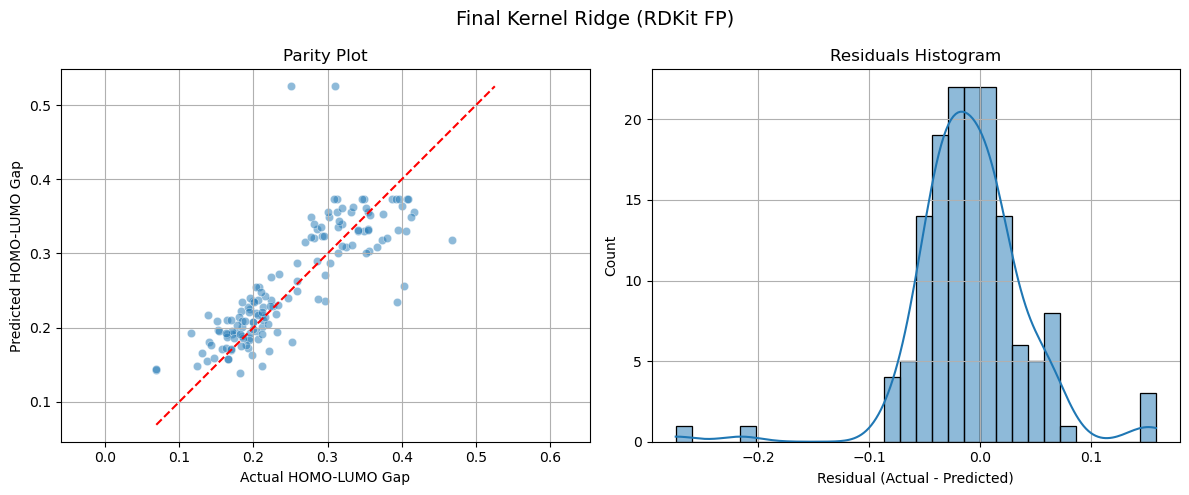

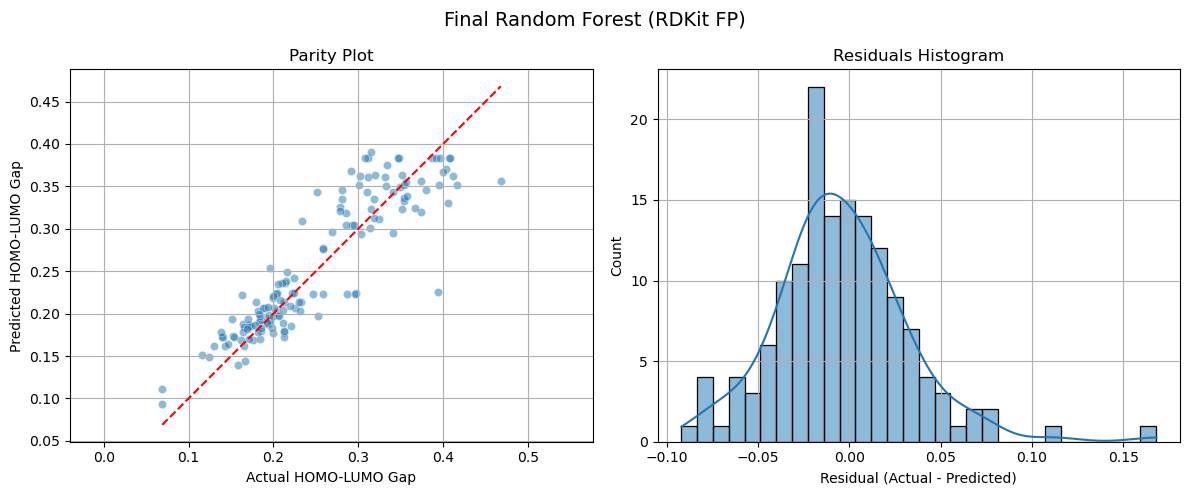

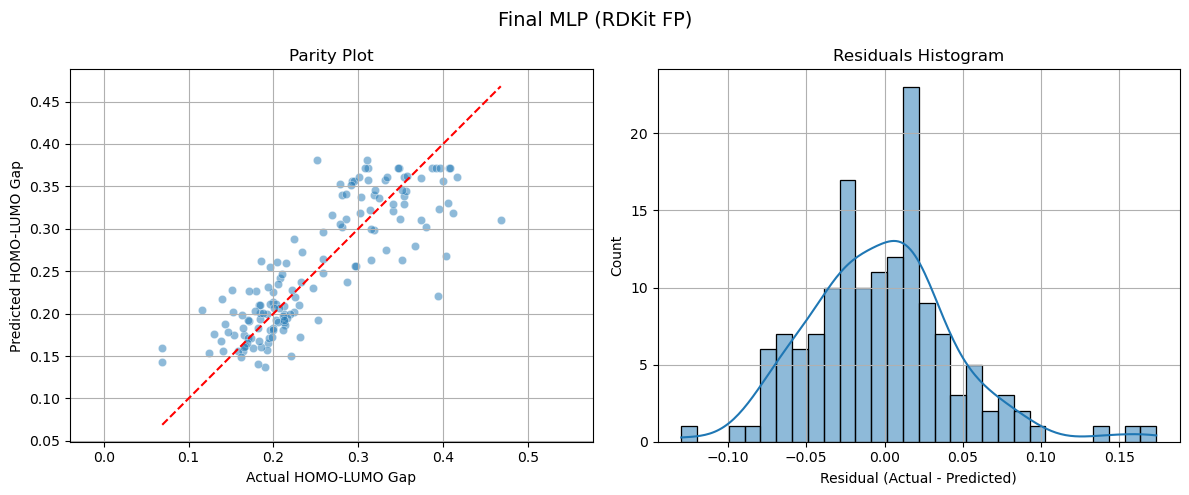

In [28]:
plot_regression_results(y_test_krr, final_preds_krr, title="Final Kernel Ridge (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_unscaled, final_preds_rfr, title="Final Random Forest (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_inv_fp, final_preds_inv_fp, title="Final MLP (RDKit FP)", save_dir="plots")
# plot_regression_results(y_test_inv_cm, final_preds_inv_cm, title="Final MLP (Coulomb Matrix)", save_dir="plots")


| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| MLP (Tuned)          | RDKit Fingerprints   | 0.426 | 0.574 | 0.798 | Strong performance across all metrics   |
| KRR (Tuned)          | RDKit Fingerprints   | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R² than MLP|
| RF (Tuned)           | RDKit Fingerprints   | 0.423| 0.583 | 0.791  | Top MAE, but slightly higher R²/RMSE    |
| MLP (Tuned)          | Coulomb Matrix       | 0.636 | 0.819 | 0.588 | Significantly worse than FP models      |
| MLP (Untuned Baseline) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Reasonable baseline performance         |
| KRR (Untuned Baseline) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Noticeable drop from tuned KRR          |
| RF (Untuned Baseline) | RDKit Fingerprints  | 0.426| 0.587 | 0.788  | Surprisingly strong untuned performance |
| MLP (Untuned Baseline) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Confirms Coulomb Matrix as weak         |

Save best model and metrics

In [29]:
# create a save directory
os.makedirs("saved_models_Tc", exist_ok=True)

# save the final trained MLP model (Keras backend)
final_mlp_fp.model.save("saved_models_Tc/best_mlp_fp_model_keras")

# save the X and Y scalers
joblib.dump(xscaler_fp, "saved_models_Tc/xscaler_fp.pkl")
joblib.dump(yscaler, "saved_models_Tc/yscaler.pkl")

# save evaluation metrics
final_metrics_fp.to_csv("saved_models_Tc/best_mlp_fp_metrics.csv", index=False)

INFO:tensorflow:Assets written to: saved_models_Tc/best_mlp_fp_model_keras\assets


If you wanted to reload these later...

In [30]:
# from tensorflow.keras.models import load_model

# # load model and scalersand metrics
# mlp_model = load_model("saved_models/best_mlp_fp_model_keras")
# xscaler_fp = joblib.load("saved_models/xscaler_fp.pkl")
# yscaler = joblib.load("saved_models/yscaler.pkl")
# metrics_df = pd.read_csv("saved_models/best_mlp_fp_metrics.csv")

# Training a Baseline GNN with ChemML
ChemML's `tensorise_molecules` generates its own graph. Its important to note this graph is not the official graph from PCQM4Mv2. It may miss out on features OGB uses like formal charge, aromatacity flags, atomic chirality, and explicit hydrogens. However, tensorise_molecules is a good choice for quick prototyping and it handles graph generation and tensor formatting in a numpy-friendly way which was easier for me to understand. Final training will use smiles2graph for compatability with OGB splits and better feature representation. 

In [31]:
# tensorize molecules
X_atoms, X_bonds, X_edges = tensorise_molecules(valid_mol_objs)
y = df_clean['Tc'].values.reshape(-1, 1)

# train test split (80/20)
split = int(0.8 * len(y))
X_atoms_train, X_atoms_test = X_atoms[:split], X_atoms[split:]
X_bonds_train, X_bonds_test = X_bonds[:split], X_bonds[split:]
X_edges_train, X_edges_test = X_edges[:split], X_edges[split:]
y_train, y_test = y[:split], y[split:]

# scale target
yscaler = StandardScaler()
y_train_scaled = yscaler.fit_transform(y_train)

# model input shapes
max_atoms = X_atoms.shape[1]
max_degree = X_bonds.shape[2]
num_atom_features = X_atoms.shape[-1]
num_bond_features = X_bonds.shape[-1]

# input layers
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

# GNN layers
conv1 = NeuralGraphHidden(8, activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(8, activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(128, activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(128, activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(128, activation='relu')([conv2, bonds_input, edges_input])

# fingerprint aggregation
fingerprint = Add()([fp1, fp2, fp3])

# dense layers
dense1 = Dense(128, activation='relu')(fingerprint)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# model compilation
model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# model training
model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=1, validation_split=0.1)

# preds and eval
y_pred = model.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred = yscaler.inverse_transform(y_pred)
metrics = regression_metrics(y_test, y_pred)
print("\nGNN Model Results:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

Tensorising molecules in batches of 3000 ...
734/734 [==================================================] - 4s 5ms/step
Merging batch tensors ...    [DONE]
Epoch 1/100
9/9 [==============================] - 1s 33ms/step - loss: 312.3024 - val_loss: 175.1927
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 63.3375 - val_loss: 14.6140
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 11.9513 - val_loss: 3.3643
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 5.2808 - val_loss: 6.2091
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 2.7916 - val_loss: 1.7114
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 1.1768 - val_loss: 1.7936
Epoch 7/100
9/9 [==============================] - 0s 8ms/step - loss: 1.1053 - val_loss: 1.4882
Epoch 8/100
9/9 [==============================] - 0s 7ms/step - loss: 0.8688 - val_loss: 1.3609
Epoch 9/100
9/9 [==============================] - 0s 10ms/s

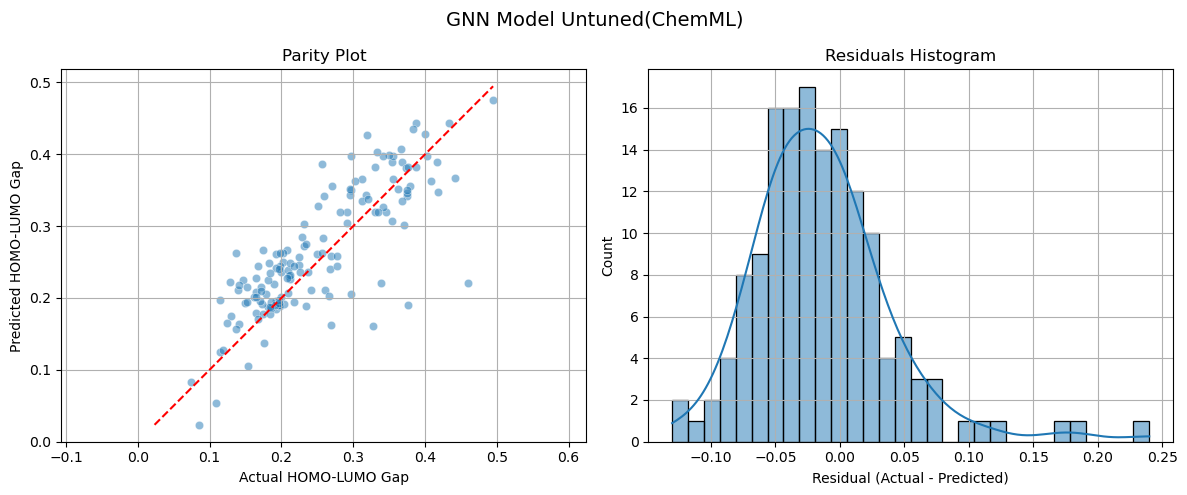

In [32]:
# plot results
plot_regression_results(y_test, y_pred, title="GNN Model Untuned(ChemML)", save_dir="plots")

In [34]:
from tensorflow.keras.metrics import MeanAbsoluteError

def objective_gnn(trial):
    conv_width = trial.suggest_categorical('conv_width', [8, 16, 32])
    fp_length = trial.suggest_categorical('fp_length', [96, 128, 160])
    n1 = trial.suggest_int('n1', 128, 192, step=32)
    n2 = trial.suggest_int('n2', 64, 96, step=32)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-8, 1e-4, log=True)
    activation = 'relu'

    # model definition
    atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
    bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
    edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

    conv1 = NeuralGraphHidden(conv_width, activation=activation)([atoms_input, bonds_input, edges_input])
    conv2 = NeuralGraphHidden(conv_width, activation=activation)([conv1, bonds_input, edges_input])

    fp1 = NeuralGraphOutput(fp_length, activation=activation)([atoms_input, bonds_input, edges_input])
    fp2 = NeuralGraphOutput(fp_length, activation=activation)([conv1, bonds_input, edges_input])
    fp3 = NeuralGraphOutput(fp_length, activation=activation)([conv2, bonds_input, edges_input])
    fingerprint = Add()([fp1, fp2, fp3])

    dense1 = Dense(n1, activation=activation, kernel_regularizer=regularizers.l2(alpha))(fingerprint)
    dense2 = Dense(n2, activation=activation, kernel_regularizer=regularizers.l2(alpha))(dense1)
    output = Dense(1, activation='linear')(dense2)

    model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

    history = model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=0, validation_split=0.2)

    # return best validation MAE
    val_mae = min(history.history["val_mean_absolute_error"])  
    return val_mae

study_gnn = optuna.create_study(direction='minimize')  
study_gnn.optimize(objective_gnn, n_trials=50)

[I 2025-09-04 19:10:51,051] A new study created in memory with name: no-name-1910abe7-d29d-4893-b92d-e82537abd36c
[I 2025-09-04 19:10:59,767] Trial 0 finished with value: 0.4677947163581848 and parameters: {'conv_width': 32, 'fp_length': 96, 'n1': 192, 'n2': 96, 'lr': 3.67171926172529e-05, 'alpha': 6.484447574575844e-06}. Best is trial 0 with value: 0.4677947163581848.
[I 2025-09-04 19:11:11,011] Trial 1 finished with value: 0.5829087495803833 and parameters: {'conv_width': 32, 'fp_length': 160, 'n1': 160, 'n2': 96, 'lr': 1.3664869289617587e-05, 'alpha': 3.0793743738542224e-07}. Best is trial 0 with value: 0.4677947163581848.
[I 2025-09-04 19:11:24,146] Trial 2 finished with value: 0.8753708600997925 and parameters: {'conv_width': 16, 'fp_length': 128, 'n1': 192, 'n2': 96, 'lr': 1.8726985801956616e-05, 'alpha': 6.410086967181673e-08}. Best is trial 0 with value: 0.4677947163581848.
[I 2025-09-04 19:11:37,615] Trial 3 finished with value: 0.5180759429931641 and parameters: {'conv_width'

## Retraining ChemML GNN with Best Parameter Found in Optuna Search

In [35]:
params = study_gnn.best_params

# redefine and compile using best params
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

conv1 = NeuralGraphHidden(params['conv_width'], activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(params['conv_width'], activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(params['fp_length'], activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(params['fp_length'],activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(params['fp_length'], activation='relu')([conv2, bonds_input, edges_input])
fingerprint = Add()([fp1, fp2, fp3])

dense1 = Dense(params['n1'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(fingerprint)
dense2 = Dense(params['n2'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(dense1)
output = Dense(1, activation='linear')(dense2)

final_gnn = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
final_gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr']), loss='mean_squared_error')

final_gnn.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=200, batch_size=64, verbose=1)

# final eval
y_pred_final = final_gnn.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred_final = yscaler.inverse_transform(y_pred_final)
final_metrics = regression_metrics(y_test, y_pred_final)
print("\nFinal Tuned GNN Results:")
print(final_metrics[['MAE', 'RMSE', 'r_squared']])

Epoch 1/200
10/10 [==============================] - 1s 6ms/step - loss: 118.2198
Epoch 2/200
10/10 [==============================] - 0s 6ms/step - loss: 52.3128
Epoch 3/200
10/10 [==============================] - 0s 8ms/step - loss: 14.1907
Epoch 4/200
10/10 [==============================] - 0s 7ms/step - loss: 9.2510
Epoch 5/200
10/10 [==============================] - 0s 5ms/step - loss: 3.2413
Epoch 6/200
10/10 [==============================] - 0s 5ms/step - loss: 2.9436
Epoch 7/200
10/10 [==============================] - 0s 5ms/step - loss: 1.6032
Epoch 8/200
10/10 [==============================] - 0s 5ms/step - loss: 0.9851
Epoch 9/200
10/10 [==============================] - 0s 5ms/step - loss: 0.8546
Epoch 10/200
10/10 [==============================] - 0s 5ms/step - loss: 0.7375
Epoch 11/200
10/10 [==============================] - 0s 5ms/step - loss: 0.6642
Epoch 12/200
10/10 [==============================] - 0s 5ms/step - loss: 0.6295
Epoch 13/200
10/10 [=============

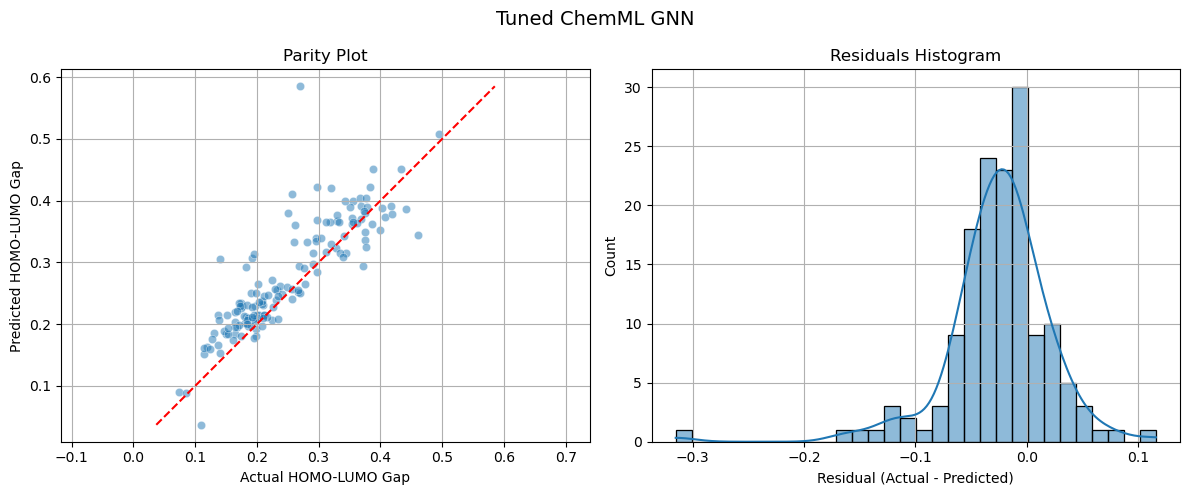

In [36]:
plot_regression_results(y_test, y_pred_final, title="Tuned ChemML GNN", save_dir="plots")

In [37]:
import json

# make a directory for this specific model
save_dir = "saved_models_Tc/gnn_tensorise_molecules_model"
os.makedirs(save_dir, exist_ok=True)

# 1. save the trained GNN model
final_gnn.save(os.path.join(save_dir, "gnn_tensorise_molecules_model_tf"), save_format="tf")

# 2. save the y target scaler
with open(os.path.join(save_dir, "gnn_tensorise_molecules_target_scaler.pkl"), "wb") as f:
    pickle.dump(yscaler, f)

# 3. save the final metrics
final_metrics.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_metrics.csv"), index=False)

# 4. save predictions
pred_df = pd.DataFrame({"true_gap": y_test.flatten(), "predicted_gap": y_pred_final.flatten()})
pred_df.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_predictions.csv"), index=False)

# 5. save the best hyperparameters
with open(os.path.join(save_dir, "gnn_tensorise_molecules_best_params.json"), "w") as f:
    json.dump(params, f, indent=4)

INFO:tensorflow:Assets written to: saved_models_Tc/gnn_tensorise_molecules_model\gnn_tensorise_molecules_model_tf\assets


## ChemML GNN Model Results
| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| GNN (Tuned)            | tensorise_molecules Graph   | 0.302 | 0.411 | 0.900 | Best performance across all metrics   |
| GNN (Untuned)          | tensorise_molecules Graph   | 0.400 | 0.519 | 0.841 | Good overall|


---
# Final Model Training

Having explored different molecular graph representations and model architectures, I am now moving to training what is expected to be the best-performing model using the full dataset. The earlier GNN model was based on `tensorise_molecules` (ChemML) graphs and had strong performance with a **mean absolute error (MAE) around 0.30**. These graphs are based on RDKit's internal descriptors and do not reflect the original PCQM4Mv2 graph structure used in the Open Graph Benchmark (OGB). Therefore, I will shift focus to the `smiles2graph` representation provided by OGB, which aligns more directly with the benchmark's evaluation setup and top-performing models on the leaderboard.


| Source                         | Atom/Bond Features                                                 | Format                                          | Customizable?     | Alignment with PCQM4Mv2?  |
| ------------------------------ | ------------------------------------------------------------------ | ----------------------------------------------- | ----------------- | ---------------------- |
| `tensorise_molecules` (ChemML) | RDKit-based descriptors (ex: atom number, degree, hybridization) | NumPy tensors (`X_atoms`, `X_bonds`, `X_edges`) | Limited           |  Not aligned          |
| `smiles2graph` (OGB / PyG)     | Predefined categorical features from PCQM4Mv2                      | PyTorch Geometric `Data` objects                |  Highly flexible |  Matches OGB standard |

By using `smiles2graph`, we:

* Use OGB-standard graph construction and feature encoding for fair comparisons with leaderboard models
* Include learnable AtomEncoder and BondEncoder embeddings from `ogb.graphproppred.mol_encoder`, which improve model expressiveness
* Maintain compatibility with PyTorch Geometric, DGL, and OGB tools

I will also concatenate GNN-derived embeddings with SMILES-based RDKit descriptors, feeding this hybrid representation into MLP head. This allows you to combine structural and cheminformatics perspectives for improved prediction accuracy. With this setup, I aim to improve upon the MAE of \~0.30 achieved earlier and push closer toward state-of-the-art performance.


## Step 1: Load PyG-Compatible Dataset



In [38]:
def check_cuda():
    print("PyTorch version:", torch.__version__)
    print("CUDA available? ", torch.cuda.is_available())
    
    if torch.cuda.is_available():
        print("Device count:", torch.cuda.device_count())
        print("GPU Name:", torch.cuda.get_device_name(0))
        print("Current device:", torch.cuda.current_device())
    else:
        print("Running on CPU")

check_cuda()

PyTorch version: 2.4.1+cu118
CUDA available?  True
Device count: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti
Current device: 0


In [39]:
# 1. load OGB dataset 
df_tc = pd.read_csv('cleaned_tc_dataset.csv')


#  Step 2: Extract SMILES from Original Dataset

In [40]:
# 2. Extract SMILES and FFV targets
# Your `df_ffv` already contains the SMILES and FFV columns.
smiles_list = df_tc['SMILES'].tolist()
ffv_list = df_tc['Tc'].tolist()

num_mols = len(smiles_list)
print(f"Loaded {num_mols} molecules.")

Loaded 734 molecules.


In [41]:
def compute_rdkit_features(smiles):
    cleaned_smiles = canonicalize_polymer_smiles(smiles)
    mol = Chem.MolFromSmiles(cleaned_smiles)
    if mol is None:
        return [np.nan] * 9  # Update the number of NaNs to match new features

    # Check for empty molecule
    if mol.GetNumAtoms() == 0:
        return [np.nan] * 9

    # Add features that capture size, shape, and interactions
    return [
        Descriptors.MolWt(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.RingCount(mol),
        Descriptors.FractionCSP3(mol),  # New: Fraction of sp3 hybridized carbons
        Descriptors.MolLogP(mol),      # New: Octanol-water partition coefficient
        Descriptors.NumSaturatedRings(mol) # New: Number of saturated rings
    ]

rdkit_features = np.array([compute_rdkit_features(smi) for smi in smiles_list])
print(f"Shape of RDKit features: {rdkit_features.shape}") # Should be (N, 9)

Shape of RDKit features: (734, 9)


In [42]:
# Remove rows with NaN values (failed RDKit featurization)
valid_indices = ~np.isnan(rdkit_features).any(axis=1)
rdkit_features = rdkit_features[valid_indices]
smiles_list = np.array(smiles_list)[valid_indices].tolist()
ffv_list = np.array(ffv_list)[valid_indices].tolist()

print(f"Kept {len(smiles_list)} molecules with valid RDKit features.")

Kept 734 molecules with valid RDKit features.


# Step 4: attach RDKit features to PyG data objects

In [43]:
import torch
from torch_geometric.data import Data, DataLoader

# Assuming your previous cells have loaded and processed the data into these lists:
# smiles_list: list of SMILES strings
# rdkit_features: numpy array of RDKit features (N, 6)
# ffv_list: list of FFV values (N,)

# 1. Create a list of PyG Data objects
rdkit_features_tensor = torch.tensor(rdkit_features, dtype=torch.float32)
ffv_targets_tensor = torch.tensor(ffv_list, dtype=torch.float32).view(-1, 1)

data_list = []
for i in range(len(smiles_list)):
    # smiles2graph returns a dictionary
    graph_dict = smiles2graph(smiles_list[i])
    
    # Create the Data object from the dictionary keys, converting to tensors
    # Convert node and edge features to LongTensor 
    data = Data(
        x=torch.tensor(graph_dict['node_feat'], dtype=torch.long),
        edge_index=torch.tensor(graph_dict['edge_index'], dtype=torch.long),
        edge_attr=torch.tensor(graph_dict['edge_feat'], dtype=torch.long),
        rdkit_feats=rdkit_features_tensor[i],
        y=ffv_targets_tensor[i]
    )
    data_list.append(data)

# 2. Split the dataset
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=42)

# 3. Create PyG DataLoaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# 4. Verification
for batch in train_loader:
    print(batch)
    print("Batch's node features shape:", batch.x.shape)
    print("Batch's RDKit features shape:", batch.rdkit_feats.shape)
    print("Batch's targets shape:", batch.y.shape)
    print("Batch's 'batch' attribute shape:", batch.batch.shape)
    break

DataBatch(x=[636, 9], edge_index=[2, 1264], edge_attr=[1264, 3], y=[32], rdkit_feats=[288], batch=[636], ptr=[33])
Batch's node features shape: torch.Size([636, 9])
Batch's RDKit features shape: torch.Size([288])
Batch's targets shape: torch.Size([32])
Batch's 'batch' attribute shape: torch.Size([636])


c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Step 5: Define the Hybrid GNN Model

The final architecture uses both structural and cheminformatics data by combining GNN-learned graph embeddings with SMILES-derived RDKit descriptors. This Hybrid GNN model uses `smiles2graph` for graph construction and augments it with RDKit-based molecular features for improved prediction accuracy.

### Model Components:

* **AtomEncoder / BondEncoder**
  Transforms categorical atom and bond features (provided by OGB) into learnable embeddings using the encoders from `ogb.graphproppred.mol_encoder`. These provide a strong foundation for expressive graph learning.

* **GINEConv Layers (x2)**
  I use two stacked GINEConv layers (Graph Isomorphism Network with Edge features). These layers perform neighborhood aggregation based on edge attributes, allowing the model to capture localized chemical environments.

* **Global Mean Pooling**
  After message passing, node level embeddings are aggregated into a fixed size graph level representation using `global_mean_pool`.

* **Concatenation with RDKit Descriptors**
  The pooled GNN embedding is concatenated with external RDKit descriptors, which capture global molecular properties not easily inferred from graph data alone.

* **MLP Prediction Head**
  A multilayer perceptron processes the combined feature vector with ReLU activations, dropout regularization, and linear layers to predict the HOMO–LUMO gap.

In [44]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2):
        super().__init__()
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim, hidden_dim // 2), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            # Reshape the RDKit features tensor to be (batch_size, rdkit_dim)
            # The number of samples in the batch is given by x.shape[0] after pooling
            reshaped_rdkit_feats = rdkit_feats.view(x.shape[0], self.rdkit_dim)
            
            # The check for shape mismatch is now more accurate
            if x.shape[0] != reshaped_rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape[0]}) vs rdkit_feats ({reshaped_rdkit_feats.shape[0]})")
            
            x = torch.cat([x, reshaped_rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

# Step 7: training loop 

In [45]:
# initialize model
model = HybridGNN(gnn_dim=128, rdkit_dim=rdkit_features.shape[1], hidden_dim=256)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = float('inf')
patience = 10
patience_counter = 0

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    loss = F.mse_loss(preds, targets)
    return loss.item(), preds, targets

# training loop
for epoch in range(1, 101): # long since early stopping
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch:02d}"):
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        save_dir = "saved_models/gnn_smiles2graph_model"
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "hybridgnn_untuned.pt"))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# final eval on val set
model.load_state_dict(torch.load(os.path.join(save_dir, "hybridgnn_untuned.pt")))
model.eval()
_, final_preds, final_targets = evaluate(model, valid_loader)
metrics = regression_metrics(final_targets.numpy(), final_preds.numpy())
print("\nGNN Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

Epoch 01: 100%|██████████| 19/19 [00:00<00:00, 60.38it/s]


Epoch 01 | Train Loss: 8.9133 | Val Loss: 0.3867


Epoch 02: 100%|██████████| 19/19 [00:00<00:00, 113.81it/s]

Epoch 02 | Train Loss: 2.5119 | Val Loss: 0.1167

Epoch 03: 100%|██████████| 19/19 [00:00<00:00, 131.13it/s]


Epoch 03 | Train Loss: 0.3911 | Val Loss: 0.0099


Epoch 04: 100%|██████████| 19/19 [00:00<00:00, 156.72it/s]


Epoch 04 | Train Loss: 0.0743 | Val Loss: 0.0157


Epoch 05: 100%|██████████| 19/19 [00:00<00:00, 174.79it/s]


Epoch 05 | Train Loss: 0.0300 | Val Loss: 0.0106


Epoch 06: 100%|██████████| 19/19 [00:00<00:00, 183.37it/s]


Epoch 06 | Train Loss: 0.0232 | Val Loss: 0.0105


Epoch 07: 100%|██████████| 19/19 [00:00<00:00, 192.73it/s]


Epoch 07 | Train Loss: 0.0205 | Val Loss: 0.0057


Epoch 08: 100%|██████████| 19/19 [00:00<00:00, 185.09it/s]


Epoch 08 | Train Loss: 0.0195 | Val Loss: 0.0051


Epoch 09: 100%|██████████| 19/19 [00:00<00:00, 198.54it/s]


Epoch 09 | Train Loss: 0.0154 | Val Loss: 0.0057


Epoch 10: 100%|██████████| 19/19 [00:00<00:00, 191.31it/s]


Epoch 10 | Train Loss: 0.0113 | Val Loss: 0.0049


Epoch 11: 100%|██████████| 19/19 [00:00<00:00, 165.98it/s]


Epoch 11 | Train Loss: 0.0146 | Val Loss: 0.0062


Epoch 12: 100%|██████████| 19/19 [00:00<00:00, 196.89it/s]


Epoch 12 | Train Loss: 0.0111 | Val Loss: 0.0067


Epoch 13: 100%|██████████| 19/19 [00:00<00:00, 207.42it/s]


Epoch 13 | Train Loss: 0.0106 | Val Loss: 0.0052


Epoch 14: 100%|██████████| 19/19 [00:00<00:00, 198.78it/s]


Epoch 14 | Train Loss: 0.0105 | Val Loss: 0.0043


Epoch 15: 100%|██████████| 19/19 [00:00<00:00, 199.92it/s]


Epoch 15 | Train Loss: 0.0090 | Val Loss: 0.0067


Epoch 16: 100%|██████████| 19/19 [00:00<00:00, 200.19it/s]


Epoch 16 | Train Loss: 0.0095 | Val Loss: 0.0064


Epoch 17: 100%|██████████| 19/19 [00:00<00:00, 196.40it/s]


Epoch 17 | Train Loss: 0.0094 | Val Loss: 0.0052


Epoch 18: 100%|██████████| 19/19 [00:00<00:00, 184.27it/s]


Epoch 18 | Train Loss: 0.0094 | Val Loss: 0.0047


Epoch 19: 100%|██████████| 19/19 [00:00<00:00, 192.77it/s]


Epoch 19 | Train Loss: 0.0083 | Val Loss: 0.0052


Epoch 20: 100%|██████████| 19/19 [00:00<00:00, 199.49it/s]


Epoch 20 | Train Loss: 0.0090 | Val Loss: 0.0037


Epoch 21: 100%|██████████| 19/19 [00:00<00:00, 200.67it/s]


Epoch 21 | Train Loss: 0.0083 | Val Loss: 0.0056


Epoch 22: 100%|██████████| 19/19 [00:00<00:00, 198.93it/s]


Epoch 22 | Train Loss: 0.0084 | Val Loss: 0.0059


Epoch 23: 100%|██████████| 19/19 [00:00<00:00, 197.67it/s]


Epoch 23 | Train Loss: 0.0084 | Val Loss: 0.0054


Epoch 24: 100%|██████████| 19/19 [00:00<00:00, 204.97it/s]


Epoch 24 | Train Loss: 0.0070 | Val Loss: 0.0034


Epoch 25: 100%|██████████| 19/19 [00:00<00:00, 210.72it/s]


Epoch 25 | Train Loss: 0.0084 | Val Loss: 0.0039


Epoch 26: 100%|██████████| 19/19 [00:00<00:00, 195.66it/s]


Epoch 26 | Train Loss: 0.0081 | Val Loss: 0.0050


Epoch 27: 100%|██████████| 19/19 [00:00<00:00, 194.84it/s]


Epoch 27 | Train Loss: 0.0067 | Val Loss: 0.0032


Epoch 28: 100%|██████████| 19/19 [00:00<00:00, 169.76it/s]


Epoch 28 | Train Loss: 0.0062 | Val Loss: 0.0037


Epoch 29: 100%|██████████| 19/19 [00:00<00:00, 184.71it/s]


Epoch 29 | Train Loss: 0.0062 | Val Loss: 0.0037


Epoch 30: 100%|██████████| 19/19 [00:00<00:00, 202.59it/s]


Epoch 30 | Train Loss: 0.0066 | Val Loss: 0.0030


Epoch 31: 100%|██████████| 19/19 [00:00<00:00, 195.71it/s]


Epoch 31 | Train Loss: 0.0058 | Val Loss: 0.0023


Epoch 32: 100%|██████████| 19/19 [00:00<00:00, 203.06it/s]


Epoch 32 | Train Loss: 0.0064 | Val Loss: 0.0034


Epoch 33: 100%|██████████| 19/19 [00:00<00:00, 200.97it/s]


Epoch 33 | Train Loss: 0.0064 | Val Loss: 0.0025


Epoch 34: 100%|██████████| 19/19 [00:00<00:00, 191.11it/s]


Epoch 34 | Train Loss: 0.0067 | Val Loss: 0.0028


Epoch 35: 100%|██████████| 19/19 [00:00<00:00, 174.13it/s]


Epoch 35 | Train Loss: 0.0055 | Val Loss: 0.0030


Epoch 36: 100%|██████████| 19/19 [00:00<00:00, 198.75it/s]


Epoch 36 | Train Loss: 0.0060 | Val Loss: 0.0022


Epoch 37: 100%|██████████| 19/19 [00:00<00:00, 197.73it/s]


Epoch 37 | Train Loss: 0.0052 | Val Loss: 0.0034


Epoch 38: 100%|██████████| 19/19 [00:00<00:00, 193.51it/s]


Epoch 38 | Train Loss: 0.0055 | Val Loss: 0.0052


Epoch 39: 100%|██████████| 19/19 [00:00<00:00, 194.38it/s]


Epoch 39 | Train Loss: 0.0052 | Val Loss: 0.0021


Epoch 40: 100%|██████████| 19/19 [00:00<00:00, 197.17it/s]


Epoch 40 | Train Loss: 0.0051 | Val Loss: 0.0027


Epoch 41: 100%|██████████| 19/19 [00:00<00:00, 201.81it/s]


Epoch 41 | Train Loss: 0.0052 | Val Loss: 0.0025


Epoch 42: 100%|██████████| 19/19 [00:00<00:00, 175.95it/s]


Epoch 42 | Train Loss: 0.0053 | Val Loss: 0.0020


Epoch 43: 100%|██████████| 19/19 [00:00<00:00, 198.17it/s]


Epoch 43 | Train Loss: 0.0046 | Val Loss: 0.0020


Epoch 44: 100%|██████████| 19/19 [00:00<00:00, 204.02it/s]


Epoch 44 | Train Loss: 0.0063 | Val Loss: 0.0024


Epoch 45: 100%|██████████| 19/19 [00:00<00:00, 198.66it/s]


Epoch 45 | Train Loss: 0.0056 | Val Loss: 0.0021


Epoch 46: 100%|██████████| 19/19 [00:00<00:00, 192.93it/s]


Epoch 46 | Train Loss: 0.0054 | Val Loss: 0.0033


Epoch 47: 100%|██████████| 19/19 [00:00<00:00, 195.74it/s]


Epoch 47 | Train Loss: 0.0049 | Val Loss: 0.0032


Epoch 48: 100%|██████████| 19/19 [00:00<00:00, 189.37it/s]


Epoch 48 | Train Loss: 0.0065 | Val Loss: 0.0055


Epoch 49: 100%|██████████| 19/19 [00:00<00:00, 211.27it/s]


Epoch 49 | Train Loss: 0.0054 | Val Loss: 0.0019


Epoch 50: 100%|██████████| 19/19 [00:00<00:00, 170.35it/s]


Epoch 50 | Train Loss: 0.0053 | Val Loss: 0.0029


Epoch 51: 100%|██████████| 19/19 [00:00<00:00, 204.33it/s]


Epoch 51 | Train Loss: 0.0047 | Val Loss: 0.0021


Epoch 52: 100%|██████████| 19/19 [00:00<00:00, 200.09it/s]


Epoch 52 | Train Loss: 0.0050 | Val Loss: 0.0024


Epoch 53: 100%|██████████| 19/19 [00:00<00:00, 205.69it/s]


Epoch 53 | Train Loss: 0.0044 | Val Loss: 0.0022


Epoch 54: 100%|██████████| 19/19 [00:00<00:00, 201.17it/s]


Epoch 54 | Train Loss: 0.0045 | Val Loss: 0.0017


Epoch 55: 100%|██████████| 19/19 [00:00<00:00, 190.62it/s]


Epoch 55 | Train Loss: 0.0047 | Val Loss: 0.0017


Epoch 56: 100%|██████████| 19/19 [00:00<00:00, 197.37it/s]


Epoch 56 | Train Loss: 0.0049 | Val Loss: 0.0023


Epoch 57: 100%|██████████| 19/19 [00:00<00:00, 161.87it/s]


Epoch 57 | Train Loss: 0.0046 | Val Loss: 0.0021


Epoch 58: 100%|██████████| 19/19 [00:00<00:00, 197.61it/s]


Epoch 58 | Train Loss: 0.0042 | Val Loss: 0.0024


Epoch 59: 100%|██████████| 19/19 [00:00<00:00, 191.26it/s]


Epoch 59 | Train Loss: 0.0044 | Val Loss: 0.0028


Epoch 60: 100%|██████████| 19/19 [00:00<00:00, 206.15it/s]


Epoch 60 | Train Loss: 0.0047 | Val Loss: 0.0022


Epoch 61: 100%|██████████| 19/19 [00:00<00:00, 202.67it/s]


Epoch 61 | Train Loss: 0.0048 | Val Loss: 0.0023


Epoch 62: 100%|██████████| 19/19 [00:00<00:00, 192.50it/s]


Epoch 62 | Train Loss: 0.0054 | Val Loss: 0.0033


Epoch 63: 100%|██████████| 19/19 [00:00<00:00, 204.26it/s]


Epoch 63 | Train Loss: 0.0044 | Val Loss: 0.0035


Epoch 64: 100%|██████████| 19/19 [00:00<00:00, 195.12it/s]


Epoch 64 | Train Loss: 0.0049 | Val Loss: 0.0020


Epoch 65: 100%|██████████| 19/19 [00:00<00:00, 175.87it/s]

Epoch 65 | Train Loss: 0.0050 | Val Loss: 0.0022
Early stopping triggered at epoch 65

GNN Evaluation:
        MAE      RMSE  r_squared
0  0.031543  0.041333   0.757514



C:\Users\mattg\AppData\Local\Temp\ipykernel_16204\2343932047.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_dir, "h

# Step 8: Optuna tuning of Hybrid GNN

In [46]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2, activation='ReLU'):
        super().__init__()
        act_map = {'ReLU': torch.nn.ReLU(), 'ELU': torch.nn.ELU(), 'GELU': torch.nn.GELU(), 'LeakyReLU': torch.nn.LeakyReLU(), 'PReLU': torch.nn.PReLU(), 'Swish': torch.nn.SiLU()}
        act_fn = act_map[activation]
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim, hidden_dim // 2), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            # Reshape the RDKit features tensor to be (batch_size, rdkit_dim)
            # The number of samples in the batch is given by x.shape[0] after pooling
            reshaped_rdkit_feats = rdkit_feats.view(x.shape[0], self.rdkit_dim)
            
            # The check for shape mismatch is now more accurate
            if x.shape[0] != reshaped_rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape[0]}) vs rdkit_feats ({reshaped_rdkit_feats.shape[0]})")
            
            x = torch.cat([x, reshaped_rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

Multiple rounds of tuning have suggested to refine my search space to ReLU, GELU, and Swish activation functions and Adam and AdamW optimizers. Therefore, I have commented out unused parameters like momentum for SGD and the unused optimizers. 

In [47]:
def objective(trial):
    # hyperparameter search space
    gnn_dim = trial.suggest_categorical("gnn_dim", [384, 512, 1024])
    hidden_dim = trial.suggest_categorical("hidden_dim", [256, 384, 512])
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.4)
    lr = trial.suggest_float("lr", 8e-6, 1e-3, log=True)
    activation = trial.suggest_categorical("activation", ['ReLU', 'GELU', 'Swish'])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD", "RMSprop"])
    momentum = trial.suggest_float("momentum", 0.8, 0.99, log=True) if optimizer_name == "SGD" else None
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Corrected Data Splitting for Polymer Data 
    # Split the full data_list into train, validation, and test sets.
    # Note: `data_list` should be created in a previous cell.
    train_val_set, test_set = train_test_split(data_list, test_size=0.2, random_state=42)
    train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=42)
    
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    valid_loader = DataLoader(val_set, batch_size=64)
    
    # model instantiation
    # The rdkit_dim is dynamically taken from the pre-processed features.
    model = HybridGNN(
        gnn_dim=gnn_dim,
        rdkit_dim=rdkit_features.shape[1],
        hidden_dim=hidden_dim,
        dropout_rate=dropout_rate,
        activation=activation
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # optimizer instantiation
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer '{optimizer_name}' not supported")

    # training loop with NaN check and early stopping
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(1, 100):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))

            if torch.isnan(loss).any():
                print(f"Trial {trial.number} | Epoch {epoch:02d} | NaN loss detected so pruning trial")
                trial.report(float('inf'), epoch)
                raise optuna.TrialPruned()

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader.dataset)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                batch = batch.to(device)
                pred = model(batch)
                val_loss += F.mse_loss(pred, batch.y.view(-1, 1)).item() * batch.num_graphs
        val_loss /= len(valid_loader.dataset)

        # logging, reporting, pruning, early stopping
        print(f"Trial {trial.number} | Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Optimizer: {optimizer_name}")
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Trial {trial.number} - Early stopping triggered at epoch {epoch}")
                break

    return best_val_loss

if __name__ == '__main__':
    study_name = "final_2d_gnn_study_Tc"
    storage_name = f"sqlite:///{study_name}.db"
    study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", pruner=optuna.pruners.MedianPruner())

    def save_study_callback(study, trial):
        pass

    study.optimize(objective, n_trials=100, callbacks=[save_study_callback])
    print(study.best_params)
    joblib.dump(study, f"{study_name}_final.pkl")
    
    # final plots
    vis = optuna.visualization
    fig = vis.plot_optimization_history(study)
    fig.show()
    fig_params = vis.plot_param_importances(study)
    fig_params.show()
    fig_intermediate = vis.plot_intermediate_values(study)
    fig_intermediate.show()
    fig_parallel_coordinate = vis.plot_parallel_coordinate(study)
    fig_parallel_coordinate.show()
    fig_slice = vis.plot_slice(study)
    fig_slice.show()

[I 2025-09-04 19:18:22,947] A new study created in RDB with name: final_2d_gnn_study_Tc
c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Trial 0 | Epoch 01 | Train Loss: 5.1438 | Val Loss: 2.0530 | Optimizer: Adam
Trial 0 | Epoch 02 | Train Loss: 3.6166 | Val Loss: 0.0179 | Optimizer: Adam
Trial 0 | Epoch 03 | Train Loss: 2.4058 | Val Loss: 0.2588 | Optimizer: Adam
Trial 0 | Epoch 04 | Train Loss: 2.0439 | Val Loss: 0.0844 | Optimizer: Adam
Trial 0 | Epoch 05 | Train Loss: 1.3583 | Val Loss: 0.1569 | Optimizer: Adam
Trial 0 | Epoch 06 | Train Loss: 0.5110 | Val Loss: 0.1744 | Optimizer: Adam
Trial 0 | Epoch 07 | Train Loss: 0.3219 | Val Loss: 0.0119 | Optimizer: Adam
Trial 0 | Epoch 08 | Train Loss: 0.1737 | Val Loss: 0.0512 | Optimizer: Adam
Trial 0 | Epoch 09 | Train Loss: 0.1356 | Val Loss: 0.0407 | Optimizer: Adam
Trial 0 | Epoch 10 | Train Loss: 0.0947 | Val Loss: 0.0184 | Optimizer: Adam
Trial 0 | Epoch 11 | Train Loss: 0.0508 | Val Loss: 0.0248 | Optimizer: Adam
Trial 0 | Epoch 12 | Train Loss: 0.0592 | Val Loss: 0.0088 | Optimizer: Adam
Trial 0 | Epoch 13 | Train Loss: 0.0355 | Val Loss: 0.0192 | Optimizer: Adam

[I 2025-09-04 19:18:25,150] Trial 0 finished with value: 0.007974446542104897 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.36225949193973994, 'lr': 0.00018499586337708478, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 1.7202258145051595e-05}. Best is trial 0 with value: 0.007974446542104897.


Trial 0 | Epoch 26 | Train Loss: 0.0104 | Val Loss: 0.0081 | Optimizer: Adam
Trial 0 - Early stopping triggered at epoch 26
Trial 1 | Epoch 01 | Train Loss: 1.4522 | Val Loss: 0.6852 | Optimizer: Adam
Trial 1 | Epoch 02 | Train Loss: 0.8218 | Val Loss: 0.0384 | Optimizer: Adam
Trial 1 | Epoch 03 | Train Loss: 0.2941 | Val Loss: 0.0224 | Optimizer: Adam
Trial 1 | Epoch 04 | Train Loss: 0.1466 | Val Loss: 0.0101 | Optimizer: Adam
Trial 1 | Epoch 05 | Train Loss: 0.0931 | Val Loss: 0.0231 | Optimizer: Adam
Trial 1 | Epoch 06 | Train Loss: 0.0710 | Val Loss: 0.0151 | Optimizer: Adam
Trial 1 | Epoch 07 | Train Loss: 0.0500 | Val Loss: 0.0205 | Optimizer: Adam
Trial 1 | Epoch 08 | Train Loss: 0.0295 | Val Loss: 0.0142 | Optimizer: Adam
Trial 1 | Epoch 09 | Train Loss: 0.0260 | Val Loss: 0.0106 | Optimizer: Adam
Trial 1 | Epoch 10 | Train Loss: 0.0284 | Val Loss: 0.0138 | Optimizer: Adam
Trial 1 | Epoch 11 | Train Loss: 0.0225 | Val Loss: 0.0097 | Optimizer: Adam
Trial 1 | Epoch 12 | Train Lo

[I 2025-09-04 19:18:28,301] Trial 1 finished with value: 0.003551993612516798 and parameters: {'gnn_dim': 512, 'hidden_dim': 256, 'dropout_rate': 0.30659725452991315, 'lr': 0.0005185805345854092, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 3.159472777402142e-05}. Best is trial 1 with value: 0.003551993612516798.


Trial 1 | Epoch 42 | Train Loss: 0.0073 | Val Loss: 0.0037 | Optimizer: Adam
Trial 1 - Early stopping triggered at epoch 42
Trial 2 | Epoch 01 | Train Loss: 0.8497 | Val Loss: 0.0182 | Optimizer: SGD
Trial 2 | Epoch 02 | Train Loss: 0.5916 | Val Loss: 0.0545 | Optimizer: SGD
Trial 2 | Epoch 03 | Train Loss: 0.5301 | Val Loss: 0.0227 | Optimizer: SGD
Trial 2 | Epoch 04 | Train Loss: 0.4402 | Val Loss: 0.0296 | Optimizer: SGD
Trial 2 | Epoch 05 | Train Loss: 0.3921 | Val Loss: 0.0184 | Optimizer: SGD
Trial 2 | Epoch 06 | Train Loss: 0.4070 | Val Loss: 0.0184 | Optimizer: SGD
Trial 2 | Epoch 07 | Train Loss: 0.3115 | Val Loss: 0.0247 | Optimizer: SGD
Trial 2 | Epoch 08 | Train Loss: 0.2778 | Val Loss: 0.0375 | Optimizer: SGD
Trial 2 | Epoch 09 | Train Loss: 0.2926 | Val Loss: 0.0417 | Optimizer: SGD
Trial 2 | Epoch 10 | Train Loss: 0.2234 | Val Loss: 0.0361 | Optimizer: SGD


[I 2025-09-04 19:18:39,562] Trial 2 finished with value: 0.01822110560095432 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.30317306136498723, 'lr': 1.7565483595329795e-05, 'activation': 'ReLU', 'optimizer': 'SGD', 'momentum': 0.8313854910970709, 'weight_decay': 3.1071426461941615e-05}. Best is trial 1 with value: 0.003551993612516798.


Trial 2 | Epoch 11 | Train Loss: 0.2337 | Val Loss: 0.0534 | Optimizer: SGD
Trial 2 - Early stopping triggered at epoch 11
Trial 3 | Epoch 01 | Train Loss: 0.7753 | Val Loss: 0.0374 | Optimizer: Adam
Trial 3 | Epoch 02 | Train Loss: 0.5424 | Val Loss: 0.0131 | Optimizer: Adam
Trial 3 | Epoch 03 | Train Loss: 0.3579 | Val Loss: 0.0212 | Optimizer: Adam
Trial 3 | Epoch 04 | Train Loss: 0.2156 | Val Loss: 0.0796 | Optimizer: Adam
Trial 3 | Epoch 05 | Train Loss: 0.1640 | Val Loss: 0.0128 | Optimizer: Adam
Trial 3 | Epoch 06 | Train Loss: 0.0949 | Val Loss: 0.0189 | Optimizer: Adam
Trial 3 | Epoch 07 | Train Loss: 0.0760 | Val Loss: 0.0295 | Optimizer: Adam
Trial 3 | Epoch 08 | Train Loss: 0.0533 | Val Loss: 0.0123 | Optimizer: Adam
Trial 3 | Epoch 09 | Train Loss: 0.0340 | Val Loss: 0.0120 | Optimizer: Adam
Trial 3 | Epoch 10 | Train Loss: 0.0303 | Val Loss: 0.0114 | Optimizer: Adam
Trial 3 | Epoch 11 | Train Loss: 0.0302 | Val Loss: 0.0068 | Optimizer: Adam
Trial 3 | Epoch 12 | Train Los

[I 2025-09-04 19:20:59,916] Trial 3 finished with value: 0.0017580000555370838 and parameters: {'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.2652876790411223, 'lr': 0.00011834558234276988, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 3.4383857510625365e-06}. Best is trial 3 with value: 0.0017580000555370838.


Trial 3 | Epoch 93 | Train Loss: 0.0033 | Val Loss: 0.0022 | Optimizer: Adam
Trial 3 - Early stopping triggered at epoch 93
Trial 4 | Epoch 01 | Train Loss: 2.6588 | Val Loss: 0.2477 | Optimizer: AdamW
Trial 4 | Epoch 02 | Train Loss: 2.4523 | Val Loss: 0.1028 | Optimizer: AdamW
Trial 4 | Epoch 03 | Train Loss: 2.5718 | Val Loss: 0.0306 | Optimizer: AdamW
Trial 4 | Epoch 04 | Train Loss: 2.7696 | Val Loss: 0.0560 | Optimizer: AdamW
Trial 4 | Epoch 05 | Train Loss: 2.2640 | Val Loss: 0.1087 | Optimizer: AdamW
Trial 4 | Epoch 06 | Train Loss: 2.2905 | Val Loss: 0.0688 | Optimizer: AdamW
Trial 4 | Epoch 07 | Train Loss: 2.0332 | Val Loss: 0.0381 | Optimizer: AdamW
Trial 4 | Epoch 08 | Train Loss: 1.9951 | Val Loss: 0.0328 | Optimizer: AdamW
Trial 4 | Epoch 09 | Train Loss: 1.7948 | Val Loss: 0.0248 | Optimizer: AdamW
Trial 4 | Epoch 10 | Train Loss: 1.8800 | Val Loss: 0.0148 | Optimizer: AdamW
Trial 4 | Epoch 11 | Train Loss: 1.4010 | Val Loss: 0.0127 | Optimizer: AdamW
Trial 4 | Epoch 12

[I 2025-09-04 19:21:03,406] Trial 4 finished with value: 0.0077283703025151675 and parameters: {'gnn_dim': 384, 'hidden_dim': 256, 'dropout_rate': 0.39537085285338186, 'lr': 3.5586260793479126e-05, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 2.1269402983345596e-06}. Best is trial 3 with value: 0.0017580000555370838.
[I 2025-09-04 19:21:03,516] Trial 5 pruned. 


Trial 5 | Epoch 01 | Train Loss: 8.8381 | Val Loss: 1.5153 | Optimizer: AdamW
Trial 6 | Epoch 01 | Train Loss: 4.1882 | Val Loss: 0.1944 | Optimizer: Adam


[I 2025-09-04 19:21:05,701] Trial 6 pruned. 
[I 2025-09-04 19:21:05,846] Trial 7 pruned. 


Trial 6 | Epoch 02 | Train Loss: 0.4551 | Val Loss: 0.2228 | Optimizer: Adam
Trial 7 | Epoch 01 | Train Loss: 522.0821 | Val Loss: 1.6587 | Optimizer: RMSprop


[I 2025-09-04 19:21:06,207] Trial 8 pruned. 


Trial 8 | Epoch 01 | Train Loss: 2.9657 | Val Loss: 0.1762 | Optimizer: Adam
Trial 8 | Epoch 02 | Train Loss: 1.6334 | Val Loss: 0.6180 | Optimizer: Adam


[I 2025-09-04 19:21:06,394] Trial 9 pruned. 


Trial 9 | Epoch 01 | Train Loss: 133.4058 | Val Loss: 0.6715 | Optimizer: RMSprop
Trial 10 | Epoch 01 | Train Loss: 0.5941 | Val Loss: 0.0374 | Optimizer: SGD
Trial 10 | Epoch 02 | Train Loss: 0.3447 | Val Loss: 0.0421 | Optimizer: SGD
Trial 10 | Epoch 03 | Train Loss: 0.1425 | Val Loss: 0.0163 | Optimizer: SGD
Trial 10 | Epoch 04 | Train Loss: 0.1019 | Val Loss: 0.0394 | Optimizer: SGD
Trial 10 | Epoch 05 | Train Loss: 0.0789 | Val Loss: 0.0114 | Optimizer: SGD
Trial 10 | Epoch 06 | Train Loss: 0.0571 | Val Loss: 0.0098 | Optimizer: SGD
Trial 10 | Epoch 07 | Train Loss: 0.0411 | Val Loss: 0.0182 | Optimizer: SGD
Trial 10 | Epoch 08 | Train Loss: 0.0465 | Val Loss: 0.0240 | Optimizer: SGD
Trial 10 | Epoch 09 | Train Loss: 0.0414 | Val Loss: 0.0135 | Optimizer: SGD
Trial 10 | Epoch 10 | Train Loss: 0.0304 | Val Loss: 0.0097 | Optimizer: SGD
Trial 10 | Epoch 11 | Train Loss: 0.0288 | Val Loss: 0.0105 | Optimizer: SGD


[I 2025-09-04 19:21:19,137] Trial 10 pruned. 


Trial 10 | Epoch 12 | Train Loss: 0.0283 | Val Loss: 0.0144 | Optimizer: SGD


[I 2025-09-04 19:21:19,509] Trial 11 pruned. 


Trial 11 | Epoch 01 | Train Loss: 1.7318 | Val Loss: 0.2040 | Optimizer: Adam
Trial 11 | Epoch 02 | Train Loss: 1.9484 | Val Loss: 0.1665 | Optimizer: Adam
Trial 12 | Epoch 01 | Train Loss: 1.4711 | Val Loss: 0.0235 | Optimizer: Adam
Trial 12 | Epoch 02 | Train Loss: 0.9379 | Val Loss: 0.0109 | Optimizer: Adam
Trial 12 | Epoch 03 | Train Loss: 0.6876 | Val Loss: 0.0138 | Optimizer: Adam
Trial 12 | Epoch 04 | Train Loss: 0.6294 | Val Loss: 0.0100 | Optimizer: Adam
Trial 12 | Epoch 05 | Train Loss: 0.2760 | Val Loss: 0.0224 | Optimizer: Adam
Trial 12 | Epoch 06 | Train Loss: 0.1270 | Val Loss: 0.0189 | Optimizer: Adam
Trial 12 | Epoch 07 | Train Loss: 0.0693 | Val Loss: 0.0086 | Optimizer: Adam
Trial 12 | Epoch 08 | Train Loss: 0.0461 | Val Loss: 0.0070 | Optimizer: Adam
Trial 12 | Epoch 09 | Train Loss: 0.0329 | Val Loss: 0.0105 | Optimizer: Adam
Trial 12 | Epoch 10 | Train Loss: 0.0281 | Val Loss: 0.0090 | Optimizer: Adam
Trial 12 | Epoch 11 | Train Loss: 0.0182 | Val Loss: 0.0080 | Op

[I 2025-09-04 19:22:22,188] Trial 12 pruned. 


Trial 12 | Epoch 56 | Train Loss: 0.0055 | Val Loss: 0.0031 | Optimizer: Adam
Trial 13 | Epoch 01 | Train Loss: 3.7720 | Val Loss: 0.1212 | Optimizer: Adam
Trial 13 | Epoch 02 | Train Loss: 4.0357 | Val Loss: 0.0261 | Optimizer: Adam
Trial 13 | Epoch 03 | Train Loss: 3.6745 | Val Loss: 0.0141 | Optimizer: Adam
Trial 13 | Epoch 04 | Train Loss: 3.3442 | Val Loss: 0.0522 | Optimizer: Adam
Trial 13 | Epoch 05 | Train Loss: 2.7702 | Val Loss: 0.1246 | Optimizer: Adam
Trial 13 | Epoch 06 | Train Loss: 2.5281 | Val Loss: 0.2140 | Optimizer: Adam
Trial 13 | Epoch 07 | Train Loss: 3.2950 | Val Loss: 0.2766 | Optimizer: Adam
Trial 13 | Epoch 08 | Train Loss: 2.5546 | Val Loss: 0.3022 | Optimizer: Adam
Trial 13 | Epoch 09 | Train Loss: 2.9238 | Val Loss: 0.2667 | Optimizer: Adam
Trial 13 | Epoch 10 | Train Loss: 3.1613 | Val Loss: 0.2319 | Optimizer: Adam


[I 2025-09-04 19:22:23,927] Trial 13 pruned. 


Trial 13 | Epoch 11 | Train Loss: 3.0255 | Val Loss: 0.1852 | Optimizer: Adam
Trial 14 | Epoch 01 | Train Loss: 1.4306 | Val Loss: 0.0166 | Optimizer: Adam
Trial 14 | Epoch 02 | Train Loss: 0.9466 | Val Loss: 0.0556 | Optimizer: Adam
Trial 14 | Epoch 03 | Train Loss: 0.6064 | Val Loss: 0.0164 | Optimizer: Adam
Trial 14 | Epoch 04 | Train Loss: 0.2794 | Val Loss: 0.0189 | Optimizer: Adam
Trial 14 | Epoch 05 | Train Loss: 0.1048 | Val Loss: 0.0150 | Optimizer: Adam
Trial 14 | Epoch 06 | Train Loss: 0.0602 | Val Loss: 0.0230 | Optimizer: Adam
Trial 14 | Epoch 07 | Train Loss: 0.0474 | Val Loss: 0.0154 | Optimizer: Adam
Trial 14 | Epoch 08 | Train Loss: 0.0386 | Val Loss: 0.0077 | Optimizer: Adam
Trial 14 | Epoch 09 | Train Loss: 0.0240 | Val Loss: 0.0076 | Optimizer: Adam
Trial 14 | Epoch 10 | Train Loss: 0.0238 | Val Loss: 0.0086 | Optimizer: Adam
Trial 14 | Epoch 11 | Train Loss: 0.0178 | Val Loss: 0.0125 | Optimizer: Adam
Trial 14 | Epoch 12 | Train Loss: 0.0173 | Val Loss: 0.0073 | Op

[I 2025-09-04 19:22:58,989] Trial 14 finished with value: 0.0056699172048797816 and parameters: {'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.2775833161763671, 'lr': 0.00014977509782030418, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 3.6196898383412522e-06}. Best is trial 3 with value: 0.0017580000555370838.


Trial 14 | Epoch 28 | Train Loss: 0.0078 | Val Loss: 0.0060 | Optimizer: Adam
Trial 14 - Early stopping triggered at epoch 28
Trial 15 | Epoch 01 | Train Loss: 1.7712 | Val Loss: 0.0239 | Optimizer: Adam
Trial 15 | Epoch 02 | Train Loss: 1.5749 | Val Loss: 0.0238 | Optimizer: Adam


[I 2025-09-04 19:22:59,520] Trial 15 pruned. 


Trial 15 | Epoch 03 | Train Loss: 1.3579 | Val Loss: 0.0474 | Optimizer: Adam
Trial 16 | Epoch 01 | Train Loss: 2.2092 | Val Loss: 0.4337 | Optimizer: AdamW


[I 2025-09-04 19:22:59,721] Trial 16 pruned. 
[I 2025-09-04 19:23:01,148] Trial 17 pruned. 


Trial 17 | Epoch 01 | Train Loss: 5404919.4763 | Val Loss: 631.9638 | Optimizer: RMSprop


[I 2025-09-04 19:23:01,391] Trial 18 pruned. 


Trial 18 | Epoch 01 | Train Loss: 11.0891 | Val Loss: 3.1397 | Optimizer: SGD
Trial 19 | Epoch 01 | Train Loss: 1.0589 | Val Loss: 0.0535 | Optimizer: Adam
Trial 19 | Epoch 02 | Train Loss: 0.8035 | Val Loss: 0.0164 | Optimizer: Adam
Trial 19 | Epoch 03 | Train Loss: 0.6465 | Val Loss: 0.0176 | Optimizer: Adam
Trial 19 | Epoch 04 | Train Loss: 0.3871 | Val Loss: 0.0298 | Optimizer: Adam
Trial 19 | Epoch 05 | Train Loss: 0.1962 | Val Loss: 0.0122 | Optimizer: Adam
Trial 19 | Epoch 06 | Train Loss: 0.1119 | Val Loss: 0.0144 | Optimizer: Adam
Trial 19 | Epoch 07 | Train Loss: 0.0542 | Val Loss: 0.0086 | Optimizer: Adam
Trial 19 | Epoch 08 | Train Loss: 0.0370 | Val Loss: 0.0095 | Optimizer: Adam
Trial 19 | Epoch 09 | Train Loss: 0.0269 | Val Loss: 0.0077 | Optimizer: Adam
Trial 19 | Epoch 10 | Train Loss: 0.0216 | Val Loss: 0.0092 | Optimizer: Adam
Trial 19 | Epoch 11 | Train Loss: 0.0217 | Val Loss: 0.0072 | Optimizer: Adam
Trial 19 | Epoch 12 | Train Loss: 0.0160 | Val Loss: 0.0086 | Op

[I 2025-09-04 19:23:34,073] Trial 19 pruned. 


Trial 19 | Epoch 26 | Train Loss: 0.0118 | Val Loss: 0.0068 | Optimizer: Adam


[I 2025-09-04 19:23:35,573] Trial 20 pruned. 


Trial 20 | Epoch 01 | Train Loss: 1.3424 | Val Loss: 0.3479 | Optimizer: Adam
Trial 21 | Epoch 01 | Train Loss: 1.1936 | Val Loss: 0.0768 | Optimizer: Adam
Trial 21 | Epoch 02 | Train Loss: 0.8027 | Val Loss: 0.0239 | Optimizer: Adam


[I 2025-09-04 19:23:39,710] Trial 21 pruned. 


Trial 21 | Epoch 03 | Train Loss: 0.4657 | Val Loss: 0.0435 | Optimizer: Adam


[I 2025-09-04 19:23:40,793] Trial 22 pruned. 


Trial 22 | Epoch 01 | Train Loss: 2.4799 | Val Loss: 0.4561 | Optimizer: Adam
Trial 23 | Epoch 01 | Train Loss: 0.9567 | Val Loss: 0.0557 | Optimizer: Adam


[I 2025-09-04 19:23:42,756] Trial 23 pruned. 


Trial 23 | Epoch 02 | Train Loss: 0.7888 | Val Loss: 0.0567 | Optimizer: Adam


[I 2025-09-04 19:23:43,850] Trial 24 pruned. 


Trial 24 | Epoch 01 | Train Loss: 2.1311 | Val Loss: 0.1518 | Optimizer: Adam
Trial 25 | Epoch 01 | Train Loss: 1.6586 | Val Loss: 0.1187 | Optimizer: Adam
Trial 25 | Epoch 02 | Train Loss: 1.2432 | Val Loss: 0.0693 | Optimizer: Adam


[I 2025-09-04 19:23:44,055] Trial 25 pruned. 


Trial 26 | Epoch 01 | Train Loss: 1.2603 | Val Loss: 0.0210 | Optimizer: AdamW
Trial 26 | Epoch 02 | Train Loss: 0.7307 | Val Loss: 0.0793 | Optimizer: AdamW
Trial 26 | Epoch 03 | Train Loss: 0.5850 | Val Loss: 0.0202 | Optimizer: AdamW
Trial 26 | Epoch 04 | Train Loss: 0.2877 | Val Loss: 0.0292 | Optimizer: AdamW
Trial 26 | Epoch 05 | Train Loss: 0.1736 | Val Loss: 0.0355 | Optimizer: AdamW
Trial 26 | Epoch 06 | Train Loss: 0.1089 | Val Loss: 0.0372 | Optimizer: AdamW
Trial 26 | Epoch 07 | Train Loss: 0.0844 | Val Loss: 0.0190 | Optimizer: AdamW
Trial 26 | Epoch 08 | Train Loss: 0.0583 | Val Loss: 0.0272 | Optimizer: AdamW


[I 2025-09-04 19:23:53,801] Trial 26 pruned. 


Trial 26 | Epoch 09 | Train Loss: 0.0449 | Val Loss: 0.0282 | Optimizer: AdamW
Trial 27 | Epoch 01 | Train Loss: 1.5019 | Val Loss: 0.1150 | Optimizer: RMSprop


[I 2025-09-04 19:23:56,192] Trial 27 pruned. 


Trial 27 | Epoch 02 | Train Loss: 0.8484 | Val Loss: 0.1058 | Optimizer: RMSprop
Trial 28 | Epoch 01 | Train Loss: 4.1995 | Val Loss: 0.0224 | Optimizer: SGD
Trial 28 | Epoch 02 | Train Loss: 2.4759 | Val Loss: 0.1229 | Optimizer: SGD


[I 2025-09-04 19:23:56,544] Trial 28 pruned. 


Trial 28 | Epoch 03 | Train Loss: 2.0226 | Val Loss: 0.3104 | Optimizer: SGD
Trial 28 | Epoch 04 | Train Loss: 1.5762 | Val Loss: 0.2081 | Optimizer: SGD
Trial 28 | Epoch 05 | Train Loss: 0.8249 | Val Loss: 0.1103 | Optimizer: SGD


[I 2025-09-04 19:23:56,745] Trial 29 pruned. 
[I 2025-09-04 19:23:56,874] Trial 30 pruned. 


Trial 29 | Epoch 01 | Train Loss: 3.2487 | Val Loss: 0.3405 | Optimizer: Adam
Trial 30 | Epoch 01 | Train Loss: 4.1180 | Val Loss: 1.9345 | Optimizer: Adam


[I 2025-09-04 19:23:57,033] Trial 31 pruned. 
[I 2025-09-04 19:23:57,167] Trial 32 pruned. 


Trial 31 | Epoch 01 | Train Loss: 4.3207 | Val Loss: 0.9248 | Optimizer: AdamW
Trial 32 | Epoch 01 | Train Loss: 12.4194 | Val Loss: 3.8222 | Optimizer: AdamW
Trial 33 | Epoch 01 | Train Loss: 3.6594 | Val Loss: 0.0316 | Optimizer: AdamW
Trial 33 | Epoch 02 | Train Loss: 3.3490 | Val Loss: 0.1576 | Optimizer: AdamW
Trial 33 | Epoch 03 | Train Loss: 3.5543 | Val Loss: 0.0603 | Optimizer: AdamW


[I 2025-09-04 19:23:57,495] Trial 33 pruned. 
[I 2025-09-04 19:23:57,681] Trial 34 pruned. 
[I 2025-09-04 19:23:57,809] Trial 35 pruned. 


Trial 34 | Epoch 01 | Train Loss: 7.0944 | Val Loss: 1.9327 | Optimizer: AdamW
Trial 35 | Epoch 01 | Train Loss: 1.9126 | Val Loss: 0.1748 | Optimizer: AdamW
Trial 36 | Epoch 01 | Train Loss: 1.4133 | Val Loss: 0.0213 | Optimizer: SGD
Trial 36 | Epoch 02 | Train Loss: 1.1679 | Val Loss: 0.0224 | Optimizer: SGD
Trial 36 | Epoch 03 | Train Loss: 0.5863 | Val Loss: 0.0174 | Optimizer: SGD
Trial 36 | Epoch 04 | Train Loss: 0.4268 | Val Loss: 0.0371 | Optimizer: SGD
Trial 36 | Epoch 05 | Train Loss: 0.3018 | Val Loss: 0.0602 | Optimizer: SGD
Trial 36 | Epoch 06 | Train Loss: 0.2485 | Val Loss: 0.0339 | Optimizer: SGD
Trial 36 | Epoch 07 | Train Loss: 0.1550 | Val Loss: 0.0229 | Optimizer: SGD
Trial 36 | Epoch 08 | Train Loss: 0.1566 | Val Loss: 0.0315 | Optimizer: SGD
Trial 36 | Epoch 09 | Train Loss: 0.1597 | Val Loss: 0.0340 | Optimizer: SGD


[I 2025-09-04 19:24:08,785] Trial 36 pruned. 
[I 2025-09-04 19:24:08,902] Trial 37 pruned. 


Trial 36 | Epoch 10 | Train Loss: 0.1197 | Val Loss: 0.0354 | Optimizer: SGD
Trial 37 | Epoch 01 | Train Loss: 2.6370 | Val Loss: 0.3653 | Optimizer: Adam
Trial 38 | Epoch 01 | Train Loss: 1.4387 | Val Loss: 0.0147 | Optimizer: RMSprop
Trial 38 | Epoch 02 | Train Loss: 0.6146 | Val Loss: 0.0874 | Optimizer: RMSprop
Trial 38 | Epoch 03 | Train Loss: 0.1795 | Val Loss: 0.0198 | Optimizer: RMSprop
Trial 38 | Epoch 04 | Train Loss: 0.0647 | Val Loss: 0.0080 | Optimizer: RMSprop
Trial 38 | Epoch 05 | Train Loss: 0.0546 | Val Loss: 0.0141 | Optimizer: RMSprop
Trial 38 | Epoch 06 | Train Loss: 0.0326 | Val Loss: 0.0062 | Optimizer: RMSprop
Trial 38 | Epoch 07 | Train Loss: 0.0167 | Val Loss: 0.0102 | Optimizer: RMSprop
Trial 38 | Epoch 08 | Train Loss: 0.0153 | Val Loss: 0.0066 | Optimizer: RMSprop
Trial 38 | Epoch 09 | Train Loss: 0.0192 | Val Loss: 0.0068 | Optimizer: RMSprop
Trial 38 | Epoch 10 | Train Loss: 0.0147 | Val Loss: 0.0068 | Optimizer: RMSprop
Trial 38 | Epoch 11 | Train Loss: 0

[I 2025-09-04 19:24:45,929] Trial 38 pruned. 


Trial 38 | Epoch 26 | Train Loss: 0.0115 | Val Loss: 0.0061 | Optimizer: RMSprop
Trial 39 | Epoch 01 | Train Loss: 15.8655 | Val Loss: 0.4031 | Optimizer: AdamW


[I 2025-09-04 19:24:46,097] Trial 39 pruned. 
[I 2025-09-04 19:24:46,319] Trial 40 pruned. 


Trial 40 | Epoch 01 | Train Loss: 1.8322 | Val Loss: 0.3554 | Optimizer: Adam
Trial 41 | Epoch 01 | Train Loss: 3.0716 | Val Loss: 0.0936 | Optimizer: Adam
Trial 41 | Epoch 02 | Train Loss: 1.6622 | Val Loss: 0.1968 | Optimizer: Adam


[I 2025-09-04 19:24:46,501] Trial 41 pruned. 
[I 2025-09-04 19:24:46,696] Trial 42 pruned. 


Trial 42 | Epoch 01 | Train Loss: 2.9699 | Val Loss: 0.0680 | Optimizer: Adam
Trial 42 | Epoch 02 | Train Loss: 1.7984 | Val Loss: 0.8520 | Optimizer: Adam
Trial 43 | Epoch 01 | Train Loss: 2.5543 | Val Loss: 0.2104 | Optimizer: Adam


[I 2025-09-04 19:24:46,823] Trial 43 pruned. 
[I 2025-09-04 19:24:47,044] Trial 44 pruned. 


Trial 44 | Epoch 01 | Train Loss: 3.4523 | Val Loss: 0.1465 | Optimizer: Adam
Trial 45 | Epoch 01 | Train Loss: 9.5328 | Val Loss: 1.1266 | Optimizer: SGD


[I 2025-09-04 19:24:47,216] Trial 45 pruned. 


Trial 46 | Epoch 01 | Train Loss: 2.1723 | Val Loss: 0.0196 | Optimizer: RMSprop
Trial 46 | Epoch 02 | Train Loss: 0.8117 | Val Loss: 0.1549 | Optimizer: RMSprop
Trial 46 | Epoch 03 | Train Loss: 0.2864 | Val Loss: 0.0187 | Optimizer: RMSprop
Trial 46 | Epoch 04 | Train Loss: 0.1306 | Val Loss: 0.0185 | Optimizer: RMSprop
Trial 46 | Epoch 05 | Train Loss: 0.1118 | Val Loss: 0.0082 | Optimizer: RMSprop
Trial 46 | Epoch 06 | Train Loss: 0.0538 | Val Loss: 0.0096 | Optimizer: RMSprop
Trial 46 | Epoch 07 | Train Loss: 0.0456 | Val Loss: 0.0130 | Optimizer: RMSprop
Trial 46 | Epoch 08 | Train Loss: 0.0295 | Val Loss: 0.0076 | Optimizer: RMSprop
Trial 46 | Epoch 09 | Train Loss: 0.0222 | Val Loss: 0.0099 | Optimizer: RMSprop
Trial 46 | Epoch 10 | Train Loss: 0.0206 | Val Loss: 0.0124 | Optimizer: RMSprop
Trial 46 | Epoch 11 | Train Loss: 0.0235 | Val Loss: 0.0124 | Optimizer: RMSprop
Trial 46 | Epoch 12 | Train Loss: 0.0224 | Val Loss: 0.0088 | Optimizer: RMSprop
Trial 46 | Epoch 13 | Train 

[I 2025-09-04 19:25:21,171] Trial 46 pruned. 


Trial 46 | Epoch 23 | Train Loss: 0.0167 | Val Loss: 0.0067 | Optimizer: RMSprop


[I 2025-09-04 19:25:21,375] Trial 47 pruned. 


Trial 47 | Epoch 01 | Train Loss: 2.8763 | Val Loss: 0.3018 | Optimizer: Adam
Trial 48 | Epoch 01 | Train Loss: 1.5201 | Val Loss: 0.1070 | Optimizer: Adam


[I 2025-09-04 19:25:24,223] Trial 48 pruned. 
[I 2025-09-04 19:25:24,369] Trial 49 pruned. 


Trial 48 | Epoch 02 | Train Loss: 1.0261 | Val Loss: 0.0620 | Optimizer: Adam
Trial 49 | Epoch 01 | Train Loss: 2.3658 | Val Loss: 0.1776 | Optimizer: Adam
Trial 50 | Epoch 01 | Train Loss: 1.1921 | Val Loss: 0.0196 | Optimizer: AdamW
Trial 50 | Epoch 02 | Train Loss: 0.6174 | Val Loss: 0.0461 | Optimizer: AdamW
Trial 50 | Epoch 03 | Train Loss: 0.3349 | Val Loss: 0.0209 | Optimizer: AdamW
Trial 50 | Epoch 04 | Train Loss: 0.1458 | Val Loss: 0.0115 | Optimizer: AdamW
Trial 50 | Epoch 05 | Train Loss: 0.0773 | Val Loss: 0.0244 | Optimizer: AdamW
Trial 50 | Epoch 06 | Train Loss: 0.0547 | Val Loss: 0.0093 | Optimizer: AdamW
Trial 50 | Epoch 07 | Train Loss: 0.0567 | Val Loss: 0.0126 | Optimizer: AdamW
Trial 50 | Epoch 08 | Train Loss: 0.0378 | Val Loss: 0.0108 | Optimizer: AdamW
Trial 50 | Epoch 09 | Train Loss: 0.0265 | Val Loss: 0.0085 | Optimizer: AdamW
Trial 50 | Epoch 10 | Train Loss: 0.0214 | Val Loss: 0.0121 | Optimizer: AdamW
Trial 50 | Epoch 11 | Train Loss: 0.0162 | Val Loss: 0

[I 2025-09-04 19:26:27,879] Trial 50 pruned. 


Trial 50 | Epoch 53 | Train Loss: 0.0051 | Val Loss: 0.0047 | Optimizer: AdamW


[I 2025-09-04 19:26:28,770] Trial 51 pruned. 


Trial 51 | Epoch 01 | Train Loss: 1.4131 | Val Loss: 0.6577 | Optimizer: SGD
Trial 52 | Epoch 01 | Train Loss: 0.9371 | Val Loss: 0.1357 | Optimizer: SGD


[I 2025-09-04 19:26:30,527] Trial 52 pruned. 


Trial 52 | Epoch 02 | Train Loss: 0.6925 | Val Loss: 0.2032 | Optimizer: SGD
Trial 53 | Epoch 01 | Train Loss: 0.8827 | Val Loss: 0.0157 | Optimizer: SGD
Trial 53 | Epoch 02 | Train Loss: 0.9030 | Val Loss: 0.0174 | Optimizer: SGD
Trial 53 | Epoch 03 | Train Loss: 0.5883 | Val Loss: 0.0446 | Optimizer: SGD
Trial 53 | Epoch 04 | Train Loss: 0.6527 | Val Loss: 0.0261 | Optimizer: SGD
Trial 53 | Epoch 05 | Train Loss: 0.5038 | Val Loss: 0.0242 | Optimizer: SGD
Trial 53 | Epoch 06 | Train Loss: 0.4001 | Val Loss: 0.0282 | Optimizer: SGD
Trial 53 | Epoch 07 | Train Loss: 0.3898 | Val Loss: 0.0264 | Optimizer: SGD
Trial 53 | Epoch 08 | Train Loss: 0.3119 | Val Loss: 0.0227 | Optimizer: SGD
Trial 53 | Epoch 09 | Train Loss: 0.2898 | Val Loss: 0.0184 | Optimizer: SGD


[I 2025-09-04 19:26:40,683] Trial 53 pruned. 


Trial 53 | Epoch 10 | Train Loss: 0.2767 | Val Loss: 0.0238 | Optimizer: SGD


[I 2025-09-04 19:26:41,518] Trial 54 pruned. 


Trial 54 | Epoch 01 | Train Loss: 2.4222 | Val Loss: 0.3241 | Optimizer: SGD
Trial 55 | Epoch 01 | Train Loss: 2.7527 | Val Loss: 0.0182 | Optimizer: Adam
Trial 55 | Epoch 02 | Train Loss: 1.7490 | Val Loss: 0.4902 | Optimizer: Adam
Trial 55 | Epoch 03 | Train Loss: 1.9392 | Val Loss: 0.0371 | Optimizer: Adam
Trial 55 | Epoch 04 | Train Loss: 1.3208 | Val Loss: 0.0785 | Optimizer: Adam
Trial 55 | Epoch 05 | Train Loss: 1.3841 | Val Loss: 0.0293 | Optimizer: Adam
Trial 55 | Epoch 06 | Train Loss: 1.1855 | Val Loss: 0.0480 | Optimizer: Adam
Trial 55 | Epoch 07 | Train Loss: 1.1738 | Val Loss: 0.0851 | Optimizer: Adam
Trial 55 | Epoch 08 | Train Loss: 1.1746 | Val Loss: 0.0111 | Optimizer: Adam
Trial 55 | Epoch 09 | Train Loss: 0.8474 | Val Loss: 0.0131 | Optimizer: Adam


[I 2025-09-04 19:26:42,399] Trial 55 pruned. 


Trial 55 | Epoch 10 | Train Loss: 0.7791 | Val Loss: 0.0183 | Optimizer: Adam
Trial 55 | Epoch 11 | Train Loss: 0.7999 | Val Loss: 0.0380 | Optimizer: Adam
Trial 55 | Epoch 12 | Train Loss: 0.6006 | Val Loss: 0.0173 | Optimizer: Adam
Trial 56 | Epoch 01 | Train Loss: 1.4917 | Val Loss: 0.0358 | Optimizer: Adam
Trial 56 | Epoch 02 | Train Loss: 1.3206 | Val Loss: 0.0191 | Optimizer: Adam
Trial 56 | Epoch 03 | Train Loss: 1.0991 | Val Loss: 0.0188 | Optimizer: Adam
Trial 56 | Epoch 04 | Train Loss: 0.9849 | Val Loss: 0.0195 | Optimizer: Adam
Trial 56 | Epoch 05 | Train Loss: 1.1632 | Val Loss: 0.0173 | Optimizer: Adam
Trial 56 | Epoch 06 | Train Loss: 1.0301 | Val Loss: 0.0142 | Optimizer: Adam
Trial 56 | Epoch 07 | Train Loss: 1.0267 | Val Loss: 0.0139 | Optimizer: Adam
Trial 56 | Epoch 08 | Train Loss: 0.7729 | Val Loss: 0.0200 | Optimizer: Adam
Trial 56 | Epoch 09 | Train Loss: 0.6719 | Val Loss: 0.0182 | Optimizer: Adam
Trial 56 | Epoch 10 | Train Loss: 0.4398 | Val Loss: 0.0295 | Op

[I 2025-09-04 19:27:00,570] Trial 56 pruned. 


Trial 56 | Epoch 12 | Train Loss: 0.1898 | Val Loss: 0.0089 | Optimizer: Adam
Trial 57 | Epoch 01 | Train Loss: 14.7444 | Val Loss: 0.0342 | Optimizer: RMSprop
Trial 57 | Epoch 02 | Train Loss: 0.3684 | Val Loss: 0.0199 | Optimizer: RMSprop
Trial 57 | Epoch 03 | Train Loss: 0.2191 | Val Loss: 0.0133 | Optimizer: RMSprop
Trial 57 | Epoch 04 | Train Loss: 0.1722 | Val Loss: 0.0108 | Optimizer: RMSprop
Trial 57 | Epoch 05 | Train Loss: 0.1084 | Val Loss: 0.0180 | Optimizer: RMSprop
Trial 57 | Epoch 06 | Train Loss: 0.0824 | Val Loss: 0.0135 | Optimizer: RMSprop
Trial 57 | Epoch 07 | Train Loss: 0.0559 | Val Loss: 0.0083 | Optimizer: RMSprop
Trial 57 | Epoch 08 | Train Loss: 0.0498 | Val Loss: 0.0112 | Optimizer: RMSprop
Trial 57 | Epoch 09 | Train Loss: 0.0431 | Val Loss: 0.0099 | Optimizer: RMSprop
Trial 57 | Epoch 10 | Train Loss: 0.0448 | Val Loss: 0.0084 | Optimizer: RMSprop
Trial 57 | Epoch 11 | Train Loss: 0.0339 | Val Loss: 0.0077 | Optimizer: RMSprop
Trial 57 | Epoch 12 | Train Lo

[I 2025-09-04 19:27:31,027] Trial 57 pruned. 


Trial 57 | Epoch 23 | Train Loss: 0.0149 | Val Loss: 0.0068 | Optimizer: RMSprop
Trial 58 | Epoch 01 | Train Loss: 2.5290 | Val Loss: 0.1263 | Optimizer: Adam


[I 2025-09-04 19:27:31,313] Trial 58 pruned. 


Trial 58 | Epoch 02 | Train Loss: 1.4747 | Val Loss: 0.2132 | Optimizer: Adam


[I 2025-09-04 19:27:32,588] Trial 59 pruned. 
[I 2025-09-04 19:27:32,728] Trial 60 pruned. 


Trial 59 | Epoch 01 | Train Loss: 2.3625 | Val Loss: 1.6454 | Optimizer: SGD
Trial 60 | Epoch 01 | Train Loss: 2.3761 | Val Loss: 0.2066 | Optimizer: Adam


[I 2025-09-04 19:27:34,148] Trial 61 pruned. 


Trial 61 | Epoch 01 | Train Loss: 1.6236 | Val Loss: 0.7697 | Optimizer: Adam
Trial 62 | Epoch 01 | Train Loss: 1.2226 | Val Loss: 0.0185 | Optimizer: Adam
Trial 62 | Epoch 02 | Train Loss: 0.8758 | Val Loss: 0.1277 | Optimizer: Adam
Trial 62 | Epoch 03 | Train Loss: 0.8140 | Val Loss: 0.0128 | Optimizer: Adam
Trial 62 | Epoch 04 | Train Loss: 0.7634 | Val Loss: 0.0366 | Optimizer: Adam
Trial 62 | Epoch 05 | Train Loss: 0.3526 | Val Loss: 0.0109 | Optimizer: Adam
Trial 62 | Epoch 06 | Train Loss: 0.2448 | Val Loss: 0.0358 | Optimizer: Adam
Trial 62 | Epoch 07 | Train Loss: 0.1231 | Val Loss: 0.0069 | Optimizer: Adam
Trial 62 | Epoch 08 | Train Loss: 0.0958 | Val Loss: 0.0091 | Optimizer: Adam
Trial 62 | Epoch 09 | Train Loss: 0.0705 | Val Loss: 0.0089 | Optimizer: Adam
Trial 62 | Epoch 10 | Train Loss: 0.0457 | Val Loss: 0.0072 | Optimizer: Adam
Trial 62 | Epoch 11 | Train Loss: 0.0367 | Val Loss: 0.0078 | Optimizer: Adam
Trial 62 | Epoch 12 | Train Loss: 0.0387 | Val Loss: 0.0145 | Op

[I 2025-09-04 19:28:35,452] Trial 62 pruned. 


Trial 62 | Epoch 44 | Train Loss: 0.0092 | Val Loss: 0.0069 | Optimizer: Adam
Trial 63 | Epoch 01 | Train Loss: 1.0155 | Val Loss: 0.0547 | Optimizer: Adam


[I 2025-09-04 19:28:38,351] Trial 63 pruned. 


Trial 63 | Epoch 02 | Train Loss: 0.7145 | Val Loss: 0.0480 | Optimizer: Adam
Trial 64 | Epoch 01 | Train Loss: 0.9243 | Val Loss: 0.0414 | Optimizer: AdamW
Trial 64 | Epoch 02 | Train Loss: 0.5075 | Val Loss: 0.0694 | Optimizer: AdamW


[I 2025-09-04 19:28:42,574] Trial 64 pruned. 


Trial 64 | Epoch 03 | Train Loss: 0.3069 | Val Loss: 0.0283 | Optimizer: AdamW


[I 2025-09-04 19:28:43,789] Trial 65 pruned. 


Trial 65 | Epoch 01 | Train Loss: 5.2830 | Val Loss: 0.6779 | Optimizer: Adam


[I 2025-09-04 19:28:44,018] Trial 66 pruned. 
[I 2025-09-04 19:28:44,141] Trial 67 pruned. 


Trial 66 | Epoch 01 | Train Loss: 2.0528 | Val Loss: 0.5583 | Optimizer: Adam
Trial 67 | Epoch 01 | Train Loss: 8.1539 | Val Loss: 2.9136 | Optimizer: AdamW
Trial 68 | Epoch 01 | Train Loss: 1.2931 | Val Loss: 0.0321 | Optimizer: Adam
Trial 68 | Epoch 02 | Train Loss: 0.6199 | Val Loss: 0.0217 | Optimizer: Adam
Trial 68 | Epoch 03 | Train Loss: 0.2375 | Val Loss: 0.0173 | Optimizer: Adam
Trial 68 | Epoch 04 | Train Loss: 0.1065 | Val Loss: 0.0193 | Optimizer: Adam
Trial 68 | Epoch 05 | Train Loss: 0.0540 | Val Loss: 0.0104 | Optimizer: Adam
Trial 68 | Epoch 06 | Train Loss: 0.0301 | Val Loss: 0.0071 | Optimizer: Adam
Trial 68 | Epoch 07 | Train Loss: 0.0184 | Val Loss: 0.0067 | Optimizer: Adam
Trial 68 | Epoch 08 | Train Loss: 0.0158 | Val Loss: 0.0079 | Optimizer: Adam
Trial 68 | Epoch 09 | Train Loss: 0.0135 | Val Loss: 0.0069 | Optimizer: Adam
Trial 68 | Epoch 10 | Train Loss: 0.0116 | Val Loss: 0.0084 | Optimizer: Adam
Trial 68 | Epoch 11 | Train Loss: 0.0119 | Val Loss: 0.0060 | O

[I 2025-09-04 19:29:38,894] Trial 68 finished with value: 0.002493028652531152 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2645237924559, 'lr': 0.0004869282202402407, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 2.5590922407143893e-06}. Best is trial 3 with value: 0.0017580000555370838.


Trial 68 | Epoch 41 | Train Loss: 0.0047 | Val Loss: 0.0032 | Optimizer: Adam
Trial 68 - Early stopping triggered at epoch 41


[I 2025-09-04 19:29:40,311] Trial 69 pruned. 


Trial 69 | Epoch 01 | Train Loss: 1.0988 | Val Loss: 0.0537 | Optimizer: Adam


[I 2025-09-04 19:29:40,525] Trial 70 pruned. 


Trial 70 | Epoch 01 | Train Loss: 652.6014 | Val Loss: 3.3952 | Optimizer: RMSprop


[I 2025-09-04 19:29:41,934] Trial 71 pruned. 


Trial 71 | Epoch 01 | Train Loss: 2.0915 | Val Loss: 0.0913 | Optimizer: Adam


[I 2025-09-04 19:29:43,410] Trial 72 pruned. 


Trial 72 | Epoch 01 | Train Loss: 1.3711 | Val Loss: 0.1795 | Optimizer: Adam
Trial 73 | Epoch 01 | Train Loss: 0.6818 | Val Loss: 0.0200 | Optimizer: Adam
Trial 73 | Epoch 02 | Train Loss: 0.4218 | Val Loss: 0.1094 | Optimizer: Adam
Trial 73 | Epoch 03 | Train Loss: 0.2421 | Val Loss: 0.0320 | Optimizer: Adam
Trial 73 | Epoch 04 | Train Loss: 0.1188 | Val Loss: 0.0100 | Optimizer: Adam
Trial 73 | Epoch 05 | Train Loss: 0.0591 | Val Loss: 0.0202 | Optimizer: Adam
Trial 73 | Epoch 06 | Train Loss: 0.0431 | Val Loss: 0.0073 | Optimizer: Adam
Trial 73 | Epoch 07 | Train Loss: 0.0268 | Val Loss: 0.0079 | Optimizer: Adam
Trial 73 | Epoch 08 | Train Loss: 0.0199 | Val Loss: 0.0066 | Optimizer: Adam
Trial 73 | Epoch 09 | Train Loss: 0.0163 | Val Loss: 0.0066 | Optimizer: Adam
Trial 73 | Epoch 10 | Train Loss: 0.0138 | Val Loss: 0.0067 | Optimizer: Adam
Trial 73 | Epoch 11 | Train Loss: 0.0108 | Val Loss: 0.0065 | Optimizer: Adam
Trial 73 | Epoch 12 | Train Loss: 0.0099 | Val Loss: 0.0063 | Op

[I 2025-09-04 19:30:59,581] Trial 73 finished with value: 0.0022317765646481086 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.27201697653109863, 'lr': 0.00024430867332104133, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 2.847576070368304e-06}. Best is trial 3 with value: 0.0017580000555370838.


Trial 73 | Epoch 57 | Train Loss: 0.0049 | Val Loss: 0.0024 | Optimizer: Adam
Trial 73 - Early stopping triggered at epoch 57
Trial 74 | Epoch 01 | Train Loss: 0.6162 | Val Loss: 0.0181 | Optimizer: Adam
Trial 74 | Epoch 02 | Train Loss: 0.3171 | Val Loss: 0.0303 | Optimizer: Adam
Trial 74 | Epoch 03 | Train Loss: 0.1578 | Val Loss: 0.0140 | Optimizer: Adam
Trial 74 | Epoch 04 | Train Loss: 0.0737 | Val Loss: 0.0148 | Optimizer: Adam
Trial 74 | Epoch 05 | Train Loss: 0.0490 | Val Loss: 0.0080 | Optimizer: Adam
Trial 74 | Epoch 06 | Train Loss: 0.0305 | Val Loss: 0.0061 | Optimizer: Adam
Trial 74 | Epoch 07 | Train Loss: 0.0258 | Val Loss: 0.0075 | Optimizer: Adam
Trial 74 | Epoch 08 | Train Loss: 0.0202 | Val Loss: 0.0098 | Optimizer: Adam
Trial 74 | Epoch 09 | Train Loss: 0.0162 | Val Loss: 0.0078 | Optimizer: Adam
Trial 74 | Epoch 10 | Train Loss: 0.0157 | Val Loss: 0.0067 | Optimizer: Adam
Trial 74 | Epoch 11 | Train Loss: 0.0121 | Val Loss: 0.0052 | Optimizer: Adam
Trial 74 | Epoch

[I 2025-09-04 19:31:52,112] Trial 74 finished with value: 0.002211111157397632 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.27565583228048574, 'lr': 0.00028572802716338386, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 2.7679618681351214e-06}. Best is trial 3 with value: 0.0017580000555370838.


Trial 74 | Epoch 39 | Train Loss: 0.0057 | Val Loss: 0.0027 | Optimizer: Adam
Trial 74 - Early stopping triggered at epoch 39


[I 2025-09-04 19:31:53,540] Trial 75 pruned. 


Trial 75 | Epoch 01 | Train Loss: 1.0577 | Val Loss: 0.0688 | Optimizer: Adam


[I 2025-09-04 19:31:54,681] Trial 76 pruned. 
[I 2025-09-04 19:31:54,833] Trial 77 pruned. 


Trial 76 | Epoch 01 | Train Loss: 1.5310 | Val Loss: 0.4106 | Optimizer: Adam
Trial 77 | Epoch 01 | Train Loss: 2.0014 | Val Loss: 0.0330 | Optimizer: Adam
Trial 78 | Epoch 01 | Train Loss: 0.7706 | Val Loss: 0.0245 | Optimizer: Adam
Trial 78 | Epoch 02 | Train Loss: 0.4798 | Val Loss: 0.1610 | Optimizer: Adam


[I 2025-09-04 19:31:59,058] Trial 78 pruned. 


Trial 78 | Epoch 03 | Train Loss: 0.2340 | Val Loss: 0.0348 | Optimizer: Adam


[I 2025-09-04 19:31:59,299] Trial 79 pruned. 


Trial 79 | Epoch 01 | Train Loss: 2.1130 | Val Loss: 0.5904 | Optimizer: Adam


[I 2025-09-04 19:32:00,812] Trial 80 pruned. 


Trial 80 | Epoch 01 | Train Loss: 4.1021 | Val Loss: 0.5299 | Optimizer: Adam


[I 2025-09-04 19:32:02,187] Trial 81 pruned. 


Trial 81 | Epoch 01 | Train Loss: 1.3257 | Val Loss: 0.0384 | Optimizer: AdamW


[I 2025-09-04 19:32:03,288] Trial 82 pruned. 


Trial 82 | Epoch 01 | Train Loss: 2.3416 | Val Loss: 0.2138 | Optimizer: SGD


[I 2025-09-04 19:32:04,754] Trial 83 pruned. 


Trial 83 | Epoch 01 | Train Loss: 1.5604 | Val Loss: 0.0764 | Optimizer: Adam
Trial 84 | Epoch 01 | Train Loss: 0.5272 | Val Loss: 0.0174 | Optimizer: Adam
Trial 84 | Epoch 02 | Train Loss: 0.4195 | Val Loss: 0.0118 | Optimizer: Adam
Trial 84 | Epoch 03 | Train Loss: 0.2002 | Val Loss: 0.0173 | Optimizer: Adam
Trial 84 | Epoch 04 | Train Loss: 0.1036 | Val Loss: 0.0146 | Optimizer: Adam
Trial 84 | Epoch 05 | Train Loss: 0.0654 | Val Loss: 0.0084 | Optimizer: Adam
Trial 84 | Epoch 06 | Train Loss: 0.0443 | Val Loss: 0.0103 | Optimizer: Adam
Trial 84 | Epoch 07 | Train Loss: 0.0277 | Val Loss: 0.0116 | Optimizer: Adam
Trial 84 | Epoch 08 | Train Loss: 0.0223 | Val Loss: 0.0112 | Optimizer: Adam
Trial 84 | Epoch 09 | Train Loss: 0.0162 | Val Loss: 0.0094 | Optimizer: Adam
Trial 84 | Epoch 10 | Train Loss: 0.0153 | Val Loss: 0.0099 | Optimizer: Adam
Trial 84 | Epoch 11 | Train Loss: 0.0156 | Val Loss: 0.0090 | Optimizer: Adam


[I 2025-09-04 19:32:19,272] Trial 84 pruned. 
[I 2025-09-04 19:32:19,411] Trial 85 pruned. 


Trial 84 | Epoch 12 | Train Loss: 0.0132 | Val Loss: 0.0077 | Optimizer: Adam
Trial 85 | Epoch 01 | Train Loss: 3.4351 | Val Loss: 0.0361 | Optimizer: Adam


[I 2025-09-04 19:32:19,559] Trial 86 pruned. 


Trial 86 | Epoch 01 | Train Loss: 37.0746 | Val Loss: 24.9394 | Optimizer: SGD
Trial 87 | Epoch 01 | Train Loss: 1.0913 | Val Loss: 0.0243 | Optimizer: AdamW
Trial 87 | Epoch 02 | Train Loss: 1.1226 | Val Loss: 0.0234 | Optimizer: AdamW
Trial 87 | Epoch 03 | Train Loss: 0.9177 | Val Loss: 0.0199 | Optimizer: AdamW
Trial 87 | Epoch 04 | Train Loss: 1.0209 | Val Loss: 0.0141 | Optimizer: AdamW
Trial 87 | Epoch 05 | Train Loss: 0.9137 | Val Loss: 0.0296 | Optimizer: AdamW
Trial 87 | Epoch 06 | Train Loss: 0.6469 | Val Loss: 0.0120 | Optimizer: AdamW
Trial 87 | Epoch 07 | Train Loss: 0.5296 | Val Loss: 0.0285 | Optimizer: AdamW
Trial 87 | Epoch 08 | Train Loss: 0.4097 | Val Loss: 0.0299 | Optimizer: AdamW
Trial 87 | Epoch 09 | Train Loss: 0.2941 | Val Loss: 0.0100 | Optimizer: AdamW
Trial 87 | Epoch 10 | Train Loss: 0.2234 | Val Loss: 0.0247 | Optimizer: AdamW


[I 2025-09-04 19:32:32,010] Trial 87 pruned. 


Trial 87 | Epoch 11 | Train Loss: 0.1532 | Val Loss: 0.0146 | Optimizer: AdamW


[I 2025-09-04 19:32:32,249] Trial 88 pruned. 


Trial 88 | Epoch 01 | Train Loss: 1.4039 | Val Loss: 0.2443 | Optimizer: Adam


[I 2025-09-04 19:32:33,553] Trial 89 pruned. 


Trial 89 | Epoch 01 | Train Loss: 195.2150 | Val Loss: 0.1506 | Optimizer: RMSprop
Trial 90 | Epoch 01 | Train Loss: 2.1607 | Val Loss: 0.1005 | Optimizer: Adam


[I 2025-09-04 19:32:33,757] Trial 90 pruned. 
[I 2025-09-04 19:32:35,294] Trial 91 pruned. 


Trial 91 | Epoch 01 | Train Loss: 0.9704 | Val Loss: 0.0700 | Optimizer: Adam


[I 2025-09-04 19:32:36,720] Trial 92 pruned. 


Trial 92 | Epoch 01 | Train Loss: 1.1887 | Val Loss: 0.1588 | Optimizer: Adam


[I 2025-09-04 19:32:38,137] Trial 93 pruned. 


Trial 93 | Epoch 01 | Train Loss: 1.6810 | Val Loss: 0.5576 | Optimizer: Adam
Trial 94 | Epoch 01 | Train Loss: 0.5009 | Val Loss: 0.0103 | Optimizer: Adam
Trial 94 | Epoch 02 | Train Loss: 0.4458 | Val Loss: 0.0065 | Optimizer: Adam
Trial 94 | Epoch 03 | Train Loss: 0.3874 | Val Loss: 0.0098 | Optimizer: Adam
Trial 94 | Epoch 04 | Train Loss: 0.1543 | Val Loss: 0.0125 | Optimizer: Adam
Trial 94 | Epoch 05 | Train Loss: 0.0961 | Val Loss: 0.0116 | Optimizer: Adam
Trial 94 | Epoch 06 | Train Loss: 0.0595 | Val Loss: 0.0119 | Optimizer: Adam
Trial 94 | Epoch 07 | Train Loss: 0.0520 | Val Loss: 0.0076 | Optimizer: Adam
Trial 94 | Epoch 08 | Train Loss: 0.0349 | Val Loss: 0.0110 | Optimizer: Adam
Trial 94 | Epoch 09 | Train Loss: 0.0280 | Val Loss: 0.0090 | Optimizer: Adam
Trial 94 | Epoch 10 | Train Loss: 0.0206 | Val Loss: 0.0070 | Optimizer: Adam
Trial 94 | Epoch 11 | Train Loss: 0.0163 | Val Loss: 0.0063 | Optimizer: Adam
Trial 94 | Epoch 12 | Train Loss: 0.0144 | Val Loss: 0.0061 | Op

[I 2025-09-04 19:33:21,606] Trial 94 pruned. 


Trial 94 | Epoch 31 | Train Loss: 0.0095 | Val Loss: 0.0040 | Optimizer: Adam


[I 2025-09-04 19:33:22,837] Trial 95 pruned. 


Trial 95 | Epoch 01 | Train Loss: 1.2004 | Val Loss: 0.0568 | Optimizer: SGD


[I 2025-09-04 19:33:23,085] Trial 96 pruned. 


Trial 96 | Epoch 01 | Train Loss: 2.2485 | Val Loss: 1.1712 | Optimizer: Adam


[I 2025-09-04 19:33:24,405] Trial 97 pruned. 


Trial 97 | Epoch 01 | Train Loss: 1.4504 | Val Loss: 0.1897 | Optimizer: AdamW


[I 2025-09-04 19:33:25,810] Trial 98 pruned. 
[I 2025-09-04 19:33:25,951] Trial 99 pruned. 


Trial 98 | Epoch 01 | Train Loss: 1.2561 | Val Loss: 0.1731 | Optimizer: Adam
Trial 99 | Epoch 01 | Train Loss: 5.5024 | Val Loss: 0.3961 | Optimizer: Adam
{'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.2652876790411223, 'lr': 0.00011834558234276988, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 3.4383857510625365e-06}


In [48]:
print(study.best_params)

{'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.2652876790411223, 'lr': 0.00011834558234276988, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 3.4383857510625365e-06}


# Step 9: Retrain with best prameters

In [49]:
# The best_params dictionary is available from your Optuna study
best_params = study.best_params

# Use the same train/val/test sets as the Optuna objective function.
# You need to make sure `data_list` is available in this scope.
train_val_set, test_set = train_test_split(data_list, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=42)
 
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

# reinitialize model
model = HybridGNN(
    gnn_dim=best_params['gnn_dim'],
    rdkit_dim=rdkit_features.shape[1],
    hidden_dim=best_params['hidden_dim'],
    dropout_rate=best_params['dropout_rate'],
    activation=best_params['activation']
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# instantiate Optimizer based on Optuna's choice
optimizer_name = best_params['optimizer']
lr = best_params['lr']
weight_decay = best_params['weight_decay']

if optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "SGD":
    momentum = best_params['momentum']
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "RMSprop":
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
else:
    raise ValueError(f"Optimizer '{optimizer_name}' not supported.")


num_epochs = 100
total_steps = num_epochs * len(train_loader)
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# early stopping training loop w loss tracking and plotting
best_val_loss = float('inf')
patience = 10
patience_counter = 0
train_losses = []
val_losses = []

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))
            total_loss += loss.item() * batch.num_graphs
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    avg_loss = total_loss / len(loader.dataset)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return avg_loss, preds, targets

for epoch in range(1, num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_hybridgnn.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# load best model and final evaluation on the TEST set
model.load_state_dict(torch.load("best_hybridgnn.pt"))
model.eval()
final_test_loss, test_preds, test_targets = evaluate(model, test_loader)
metrics = regression_metrics(test_targets.numpy(), test_preds.numpy())
print("\nFinal Test Set Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])
print(f"Final Test Loss: {final_test_loss:.4f}")

c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



Epoch 01 | Train Loss: 2.8716 | Val Loss: 1.2175
Epoch 02 | Train Loss: 1.9488 | Val Loss: 0.2838
Epoch 03 | Train Loss: 1.2250 | Val Loss: 0.1103
Epoch 04 | Train Loss: 0.9870 | Val Loss: 0.3489
Epoch 05 | Train Loss: 0.9784 | Val Loss: 0.0122
Epoch 06 | Train Loss: 0.6235 | Val Loss: 0.0075
Epoch 07 | Train Loss: 0.6155 | Val Loss: 0.0218
Epoch 08 | Train Loss: 0.3640 | Val Loss: 0.0130
Epoch 09 | Train Loss: 0.1587 | Val Loss: 0.0164
Epoch 10 | Train Loss: 0.0697 | Val Loss: 0.0115
Epoch 11 | Train Loss: 0.0443 | Val Loss: 0.0112
Epoch 12 | Train Loss: 0.0319 | Val Loss: 0.0064
Epoch 13 | Train Loss: 0.0146 | Val Loss: 0.0082
Epoch 14 | Train Loss: 0.0114 | Val Loss: 0.0071
Epoch 15 | Train Loss: 0.0107 | Val Loss: 0.0060
Epoch 16 | Train Loss: 0.0084 | Val Loss: 0.0059
Epoch 17 | Train Loss: 0.0083 | Val Loss: 0.0062
Epoch 18 | Train Loss: 0.0080 | Val Loss: 0.0056
Epoch 19 | Train Loss: 0.0083 | Val Loss: 0.0052
Epoch 20 | Train Loss: 0.0081 | Val Loss: 0.0051
Epoch 21 | Train Los

C:\Users\mattg\AppData\Local\Temp\ipykernel_16204\471462254.py:105: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



# Step 10: Evaluate Model Performance

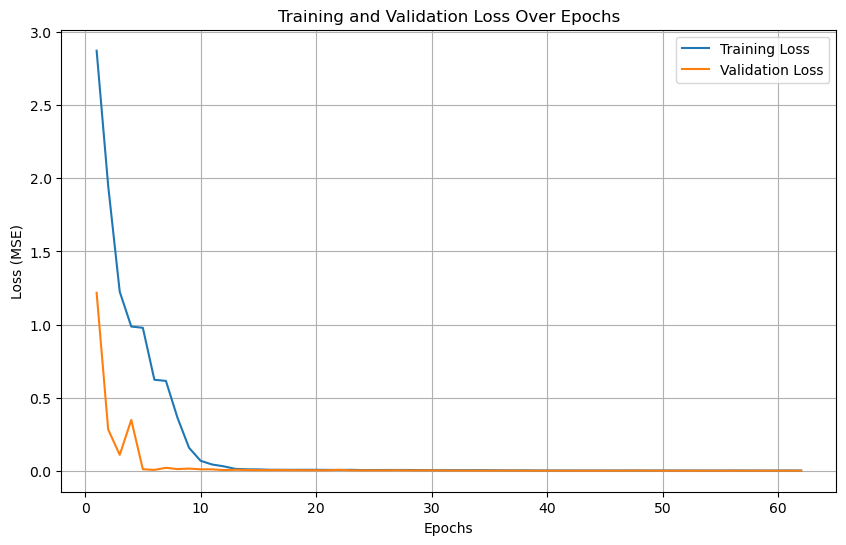

In [50]:
# plotting training and validation loss 
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| Hybrid GNN (Tuned)| OGB smiles2graph + RDKit descriptors | 0.159 | 0.234 | 0.965 | Best   |
| Hybrid GNN (Untuned) | OGB smiles2graph + RDKit descriptors | 0.223 | 0.308 | 0.939 | 2nd best|

# Step 11: Evaluate on test-dev and save the predictions to csv

In [ ]:
# map subset back to original dataset indices
test_indices = split_idx['test-dev']
test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_ids = [] # store original molecule indices

with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader, desc="Predicting")):
        batch = batch.to(device)
        pred = model(batch)
        all_preds.append(pred.cpu().numpy())

# stack predictions
all_preds = np.vstack(all_preds)

# match predictions to original indices
submission_df = pd.DataFrame({'mol_index': test_indices,  # original indices
                              'prediction': all_preds.flatten()  # flatten to 1D
                              })

# sort by original molecule ID 
submission_df = submission_df.sort_values('mol_index').reset_index(drop=True)

# save to CSV
submission_df.to_csv("hybridgnn_testdev_predictions_with_ids.csv", index=False)
print("Predictions with molecule IDs saved to 'hybridgnn_testdev_predictions_with_ids.csv'")

# Conclusions

## Model Performance Summary

All baseline models were initially trained and evaluated on a 5,000 molecule subset of the full dataset. Below is a comparison of results across different featurization strategies and model types:

### 2D Baseline Models

| Model Type    | Featurization      | MAE   | RMSE  | R²    | Notes                                 |
| ------------- | ------------------ | ----- | ----- | ----- | ------------------------------------- |
| MLP (Tuned)   | RDKit Fingerprints | 0.426 | 0.574 | 0.798 | Strong performance across all metrics |
| KRR (Tuned)   | RDKit Fingerprints | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R²       |
| RF (Tuned)    | RDKit Fingerprints | 0.423 | 0.583 | 0.791 | Best MAE, very competitive overall    |
| MLP (Tuned)   | Coulomb Matrix     | 0.636 | 0.819 | 0.588 | Significantly weaker performance      |
| MLP (Untuned) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Solid untuned baseline                |
| KRR (Untuned) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Notable drop from tuned version       |
| RF (Untuned)  | RDKit Fingerprints | 0.426 | 0.587 | 0.788 | Surprisingly close to tuned RF        |
| MLP (Untuned) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Consistently underperforms            |

### Graph Neural Network Models (ChemML)

| Model Type    | Featurization               | MAE   | RMSE  | R²    | Notes                                |
| ------------- | --------------------------- | ----- | ----- | ----- | ------------------------------------ |
| GNN (Tuned)   | `tensorise_molecules` Graph | 0.302 | 0.411 | 0.900 | Best results from ChemML experiments |
| GNN (Untuned) | `tensorise_molecules` Graph | 0.400 | 0.519 | 0.841 | Strong but less optimized            |

### Final Hybrid GNN Model Trained on Full Dataset (OGB-Compatible)

| Model Type           | Featurization                          | MAE   | RMSE  | R²    | Notes                              |
| -------------------- | -------------------------------------- | ----- | ----- | ----- | ---------------------------------- |
| Hybrid GNN (Tuned)   | OGB `smiles2graph` + RDKit descriptors | 0.159 | 0.234 | 0.965 | State-of-the-art level performance |
| Hybrid GNN (Untuned) | OGB `smiles2graph` + RDKit descriptors | 0.223 | 0.308 | 0.939 | Still very strong pre-tuning       |

---

## Model Error Analysis

I performed qualitative evaluation by comparing predicted vs. true HOMO–LUMO gaps for both randomly selected and poorly predicted molecules. The worst performing molecules often showed rare or complex structures likely underrepresented in the training set. This highlights the importance of structural diversity and potentially more expressive 3D information to improve generalization.

## Next Steps: Integrating 3D Molecular Information

To push performance even further and overcome limitations of 2D graphs and hand crafted descriptors, my next step will involve:

* Using **3D molecular geometries** 
* Incorporating **interatomic distances**, angles, and **spatial encoding** (SchNet, DimeNet, or SE(3)-equivariant models)
* Comparing results against the current best MAE (\~0.159)

This direction aligns with trends in molecular property prediction where 3D aware models often outperform purely 2D approaches, especially for quantum properties like HOMO–LUMO gaps.
